In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from MultiTimeframeCandleManager import *
from datetime import datetime, timedelta
import time
from collections import deque
import numpy as np
import copy
import tensorflow as tf
from tqdm import tqdm
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt

candles = obj_load("NQ_1")
len(candles)

loading NQ_1


99990

In [17]:
model = tf.keras.models.load_model("model.keras")
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_10            │ (None, 60, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 60, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_12            │ (None, 60, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1, 8)           │         11,520 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_9 (Flatten)       │ (None, 240)            │              0 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_10 (Flatten)      │ (None, 240)            │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_11 (Flatten)      │ (None, 240)            │              0 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_13            │ (None, 94)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_8 (Flatten)       │ (None, 8)              │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 822)            │              0 │ flatten_9[0][0],       │
│ (Concatenate)             │                        │                │ flatten_10[0][0],      │
│                           │                        │                │ flatten_11[0][0],      │
│                           │                        │                │ input_layer_13[0][0],  │
│                           │                        │                │ flatten_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 1024)           │        842,752 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 1024)           │              0 │ dense_10[0][0],        │
│                           │                        │                │ dense_11[0][0],        │
│                           │                        │                │ dense_12[0][0],        │
│                           │                        │                │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)     

 Total params: 4,004,097 (15.27 MB)

 Trainable params: 4,004,097 (15.27 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:

def relative (value, center, r):
        return (value - center) / r

def ret_to_scaled_inputs(ret):

    midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret


    center = (midnight_opening_range_high + midnight_opening_range_low) / 2
    r = max(0.0001,(midnight_opening_range_high - midnight_opening_range_low) / 2)

    pda_rel = []
    pda_rel.append(relative(midnight_open, center, r))
    for pda in pdas[0:9+9+15]:
        pda_rel.append(relative(pda, center, r))
    for index in range(9+9+15,9+9+15+5*12):
        ## highs lows are like this [h, h_taken, l, l_taken]
        ## the bools should not be scaled
        if (index - 9+9+15) % 2 == 0:
            pda_rel.append(relative(pdas[index], center, r))
        else:
            pda_rel.append(pdas[index])

    pda_np = np.array(pda_rel)

    current_minutes = current_time.hour * 60 + current_time.minute

    charts_array = []
    for candlesticks in charts:
        charts_array.append([])
        for candle in candlesticks:
            o = relative(candle.o, center, r)
            h = relative(candle.h, center, r)
            l = relative(candle.l, center, r)
            c = relative(candle.c, center, r)
            charts_array[-1].append([o,h,l,c])

    m15_np = np.array(charts_array[0])
    m5_np = np.array(charts_array[1])
    m1_np = np.array(charts_array[2])

    return [m15_np, m5_np, m1_np, pda_np, current_minutes]


# In[11]:


class Order:
    def __init__(self, limit, stop, tp, direction):
        self.entry = limit
        self.tp = tp
        self.sl = stop
        self.direction = direction

class Position:
    def __init__(self, entry, stop, tp, direction):
        self.entry = entry
        self.tp = tp
        self.sl = stop
        self.direction = direction


In [19]:
def step(index):

        global current_position, current_order, slm, m, outputs, all_candles, cmm, equity, equity_L

        ret = m.push_m1_candle(candles[index])
        midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
        center = (midnight_opening_range_high + midnight_opening_range_low) / 2
        r = max(0.0001, (midnight_opening_range_high - midnight_opening_range_low) / 2)



        current_candle_m1 = charts[2][-1]
        #### check tp before filling order so that the same m1 candle will not trigger tp - it is not sure if the candle hit first limit and later tp or reve3rse
        if current_position.direction == 1:
            if current_candle_m1.h >= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.l <= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)

        #### check order
        if current_order != None:
            if  current_order.direction == 1:
                if current_candle_m1.l < current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill long order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None
        if current_order != None:
            if  current_order.direction == -1:
                if current_candle_m1.h > current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill short order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None

        #### check sl
        if current_position.direction == 1:
            if current_candle_m1.l <= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.h >= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)




        if(len(m.ndogs) == 5 and len(m.fps) == 3 and len(m.opening_range_gaps) == 3 and len(m.asia_highs_lows) == 3 and len(m.london_highs_lows) == 3 and len(m.ny_am_highs_lows) == 3 and len(m.ny_lunch_highs_lows) == 3 and len(m.ny_pm_highs_lows) == 3):


            open_profit = (current_close - current_position.entry) * current_position.direction

            scaled_entry_diff  =  0
            scaled_sl_diff  =  0
            if(current_position.direction != 0):
                scaled_entry_diff = (current_close - current_position.entry) / r
                scaled_sl_diff = (current_close - current_position.sl) / r

            state = ret_to_scaled_inputs(ret) + [np.array([current_position.direction, scaled_entry_diff, scaled_sl_diff])]
            m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info = state

            equity_L.append(equity+open_profit)
            all_candles.append(charts[2][-1])


            if True:#current_minutes >= 9*60+29 and current_minutes < 16*60:
                output = inference_step(
                    tf.expand_dims(m15_np, 0),
                    tf.expand_dims(m5_np, 0),
                    tf.expand_dims(m1_np, 0),
                    tf.expand_dims(pda_np, 0),
                    tf.expand_dims(current_minutes, 0),
                    #tf.expand_dims(pos_info, 0)
                )

                last_action = 0
                if output[0] > t:
                    last_action = 1
                if output[0] < -t:
                    last_action = -1

                outputs.append(output[0])
            else:
                last_action = 0


            avg_candle_range = np.mean([ i.h - i.l for i in list(charts[2])])

            if(last_action == 0 and current_position.direction != 0):
                equity += open_profit
                current_position = Position(0,0,0,0)
                #print("close position:", open_profit)

            if(last_action == -1 and current_position.direction == 1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == -1 and current_position.direction == 0):
                last_candle_low = charts[2][-2].l
                if ( last_candle_low < current_close ):
                    last_candle_low = None

                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[0] > current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1])
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0])

                if(len(pdas_filtered) > 0):

                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_low[0][0]
                    if(last_candle_low != None):
                        entry = min(entry, last_candle_low)


                    sl = entry + avg_candle_range * slm
                    tp = entry  -  avg_candle_range * tpm


                    current_order = Order(entry, sl, tp, -1)
                    #print("set short order:",entry,sl,tp)



            if(last_action == 1 and current_position.direction == -1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 1 and current_position.direction == 0):
                last_candle_high = charts[2][-2].h
                if ( last_candle_high > current_close ):
                    last_candle_high = None
                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[1] < current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1], reverse=True)
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0], reverse=True)

                if(len(pdas_filtered) > 0):
                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_high[0][1]
                    if(last_candle_high != None):
                        entry = max(entry, last_candle_high)

                    sl = entry - avg_candle_range * slm
                    tp = entry  +  avg_candle_range * tpm

                    current_order = Order(entry, sl, tp, 1)
                    #print("set long order:",entry,sl,tp)



In [20]:
m = MultiTimeframeCandleManager()

t = 0.1
slm = 3
tpm = 6

current_position = Position(0,0,0,0)
current_order = None

equity = 0
equity_L = [0]

outputs = []
all_candles = []

cmm = 0.5

@tf.function()
def inference_step(m15_np, m5_np, m1_np, pda_np, current_minutes):
    return model([
        m15_np,
        m5_np,
        m1_np,
        pda_np,
        current_minutes
    ])



#for index in tqdm(range(len(candles))):
for index in tqdm(range(100000)):
    step(index)
    if( index % 100 == 0 ):
        print("\n", equity_L[-1])

print(equity_L[-1])

  3%|▎         | 2503/100000 [00:00<00:07, 12917.46it/s]


 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0


  5%|▌         | 5368/100000 [00:00<00:06, 13886.93it/s]


 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0.0

 0.5

 9.75

 -0.75

 17.799999999999272

 12.274999999997817

 15.774999999997817

 20.774999999997817


  7%|▋         | 6757/100000 [00:05<02:08, 724.92it/s]  


 20.774999999997817

 20.774999999997817

 20.774999999997817

 20.774999999997817

 20.774999999997817

 20.774999999997817

 20.774999999997817

 20.774999999997817

 20.774999999997817


  8%|▊         | 7655/100000 [00:10<03:36, 427.07it/s]


 20.024999999997817

 20.024999999997817

 20.024999999997817

 20.024999999997817

 20.024999999997817

 20.024999999997817


  8%|▊         | 8254/100000 [00:14<04:45, 321.35it/s]


 20.024999999997817

 20.024999999997817

 20.024999999997817

 73.27499999999782


  9%|▊         | 8663/100000 [00:16<05:31, 275.29it/s]


 94.19999999999709

 112.13749999999709

 108.88749999999709


  9%|▉         | 8947/100000 [00:18<05:54, 256.83it/s]


 98.88749999999709

 93.62499999999636


  9%|▉         | 9148/100000 [00:19<06:09, 245.78it/s]


 93.62499999999636


  9%|▉         | 9293/100000 [00:20<06:23, 236.82it/s]


 92.12499999999636


  9%|▉         | 9399/100000 [00:20<06:33, 230.42it/s]


 98.87499999999636


  9%|▉         | 9479/100000 [00:21<06:43, 224.42it/s]


 98.87499999999636


 10%|▉         | 9629/100000 [00:21<07:09, 210.65it/s]


 97.87499999999636


 10%|▉         | 9717/100000 [00:22<07:26, 202.20it/s]


 97.87499999999636


 10%|▉         | 9825/100000 [00:22<07:59, 188.13it/s]


 97.87499999999636


 10%|▉         | 9921/100000 [00:23<08:06, 185.08it/s]


 97.87499999999636


 10%|█         | 10038/100000 [00:24<08:09, 183.63it/s]


 97.87499999999636


 10%|█         | 10133/100000 [00:24<08:12, 182.47it/s]


 97.87499999999636


 10%|█         | 10228/100000 [00:25<08:20, 179.26it/s]


 97.87499999999636


 10%|█         | 10320/100000 [00:25<10:08, 147.38it/s]


 97.87499999999636


 10%|█         | 10426/100000 [00:26<10:22, 143.79it/s]


 97.87499999999636


 11%|█         | 10525/100000 [00:27<11:47, 126.50it/s]


 97.87499999999636


 11%|█         | 10624/100000 [00:28<10:54, 136.59it/s]


 97.87499999999636


 11%|█         | 10724/100000 [00:28<11:29, 129.43it/s]


 97.87499999999636


 11%|█         | 10829/100000 [00:29<09:35, 154.88it/s]


 97.87499999999636


 11%|█         | 10922/100000 [00:30<08:19, 178.28it/s]


 97.87499999999636


 11%|█         | 11032/100000 [00:30<08:27, 175.24it/s]


 97.87499999999636


 11%|█         | 11125/100000 [00:31<08:13, 180.16it/s]


 86.87499999999636


 11%|█         | 11238/100000 [00:31<08:07, 182.21it/s]


 66.12499999999636


 11%|█▏        | 11334/100000 [00:32<08:23, 175.92it/s]


 60.62499999999636


 11%|█▏        | 11424/100000 [00:32<08:28, 174.08it/s]


 61.12499999999636


 12%|█▏        | 11532/100000 [00:33<08:40, 169.93it/s]


 65.62499999999636


 12%|█▏        | 11626/100000 [00:34<08:08, 180.82it/s]


 65.62499999999636


 12%|█▏        | 11720/100000 [00:34<08:38, 170.30it/s]


 68.12499999999636


 12%|█▏        | 11835/100000 [00:35<08:03, 182.42it/s]


 68.12499999999636


 12%|█▏        | 11927/100000 [00:35<08:22, 175.41it/s]


 68.12499999999636


 12%|█▏        | 12022/100000 [00:36<08:04, 181.63it/s]


 68.12499999999636


 12%|█▏        | 12133/100000 [00:36<08:15, 177.24it/s]


 68.12499999999636


 12%|█▏        | 12225/100000 [00:37<08:06, 180.47it/s]


 68.12499999999636


 12%|█▏        | 12336/100000 [00:38<08:07, 179.79it/s]


 68.12499999999636


 12%|█▏        | 12427/100000 [00:38<08:29, 172.01it/s]


 68.12499999999636


 13%|█▎        | 12522/100000 [00:39<08:01, 181.69it/s]


 68.12499999999636


 13%|█▎        | 12627/100000 [00:39<10:22, 140.28it/s]


 68.12499999999636


 13%|█▎        | 12713/100000 [00:40<10:44, 135.37it/s]


 68.12499999999636


 13%|█▎        | 12822/100000 [00:41<10:52, 133.66it/s]


 68.12499999999636


 13%|█▎        | 12924/100000 [00:42<10:35, 137.12it/s]


 68.12499999999636


 13%|█▎        | 13019/100000 [00:42<11:41, 123.94it/s]


 68.12499999999636


 13%|█▎        | 13134/100000 [00:43<08:32, 169.33it/s]


 68.12499999999636


 13%|█▎        | 13226/100000 [00:44<08:23, 172.26it/s]


 68.12499999999636


 13%|█▎        | 13319/100000 [00:44<08:17, 174.41it/s]


 68.12499999999636


 13%|█▎        | 13428/100000 [00:45<08:01, 179.65it/s]


 68.12499999999636


 14%|█▎        | 13522/100000 [00:45<07:55, 181.91it/s]


 68.12499999999636


 14%|█▎        | 13636/100000 [00:46<07:55, 181.58it/s]


 68.12499999999636


 14%|█▎        | 13731/100000 [00:46<08:12, 175.16it/s]


 68.12499999999636


 14%|█▍        | 13825/100000 [00:47<08:04, 178.00it/s]


 68.12499999999636


 14%|█▍        | 13919/100000 [00:48<08:00, 179.26it/s]


 68.12499999999636


 14%|█▍        | 14033/100000 [00:48<07:50, 182.67it/s]


 68.12499999999636


 14%|█▍        | 14128/100000 [00:49<08:00, 178.79it/s]


 68.12499999999636


 14%|█▍        | 14222/100000 [00:49<07:50, 182.34it/s]


 68.12499999999636


 14%|█▍        | 14337/100000 [00:50<07:47, 183.05it/s]


 68.12499999999636


 14%|█▍        | 14432/100000 [00:50<07:42, 185.15it/s]


 68.12499999999636


 15%|█▍        | 14527/100000 [00:51<07:50, 181.52it/s]


 68.12499999999636


 15%|█▍        | 14623/100000 [00:51<07:45, 183.43it/s]


 68.12499999999636


 15%|█▍        | 14737/100000 [00:52<07:44, 183.40it/s]


 68.12499999999636


 15%|█▍        | 14832/100000 [00:53<07:50, 181.08it/s]


 68.12499999999636


 15%|█▍        | 14917/100000 [00:53<10:15, 138.20it/s]


 68.12499999999636


 15%|█▌        | 15019/100000 [00:54<10:41, 132.49it/s]


 68.12499999999636


 15%|█▌        | 15116/100000 [00:55<10:29, 134.78it/s]


 68.12499999999636


 15%|█▌        | 15215/100000 [00:55<10:24, 135.87it/s]


 68.12499999999636


 15%|█▌        | 15322/100000 [00:56<11:48, 119.51it/s]


 68.12499999999636


 15%|█▌        | 15417/100000 [00:57<09:01, 156.19it/s]


 68.12499999999636


 16%|█▌        | 15530/100000 [00:58<07:46, 181.18it/s]


 68.12499999999636


 16%|█▌        | 15626/100000 [00:58<07:46, 181.05it/s]


 68.12499999999636


 16%|█▌        | 15721/100000 [00:59<07:44, 181.37it/s]


 68.12499999999636


 16%|█▌        | 15834/100000 [00:59<07:49, 179.19it/s]


 68.12499999999636


 16%|█▌        | 15928/100000 [01:00<07:38, 183.55it/s]


 68.12499999999636


 16%|█▌        | 16023/100000 [01:00<07:38, 183.17it/s]


 68.12499999999636


 16%|█▌        | 16138/100000 [01:01<07:32, 185.36it/s]


 68.12499999999636


 16%|█▌        | 16233/100000 [01:01<07:42, 181.02it/s]


 68.12499999999636


 16%|█▋        | 16329/100000 [01:02<07:25, 187.63it/s]


 68.12499999999636


 16%|█▋        | 16425/100000 [01:02<07:37, 182.75it/s]


 68.12499999999636


 17%|█▋        | 16518/100000 [01:03<07:40, 181.12it/s]


 68.12499999999636


 17%|█▋        | 16632/100000 [01:04<07:34, 183.52it/s]


 68.12499999999636


 17%|█▋        | 16727/100000 [01:04<07:55, 175.31it/s]


 68.87499999999636


 17%|█▋        | 16822/100000 [01:05<07:26, 186.12it/s]


 72.62499999999636


 17%|█▋        | 16936/100000 [01:05<07:43, 179.08it/s]


 66.12499999999636


 17%|█▋        | 17032/100000 [01:06<07:28, 184.87it/s]


 74.12499999999636


 17%|█▋        | 17127/100000 [01:06<07:35, 181.77it/s]


 105.77499999999782


 17%|█▋        | 17216/100000 [01:07<09:34, 144.00it/s]


 116.82499999999709


 17%|█▋        | 17318/100000 [01:08<10:32, 130.76it/s]


 116.82499999999709


 17%|█▋        | 17425/100000 [01:09<10:31, 130.70it/s]


 116.82499999999709


 18%|█▊        | 17526/100000 [01:09<09:54, 138.71it/s]


 116.82499999999709


 18%|█▊        | 17620/100000 [01:10<11:52, 115.55it/s]


 116.82499999999709


 18%|█▊        | 17735/100000 [01:11<08:11, 167.42it/s]


 116.82499999999709


 18%|█▊        | 17826/100000 [01:11<07:46, 175.96it/s]


 116.82499999999709


 18%|█▊        | 17938/100000 [01:12<07:34, 180.47it/s]


 116.82499999999709


 18%|█▊        | 18034/100000 [01:13<07:38, 178.61it/s]


 116.82499999999709


 18%|█▊        | 18129/100000 [01:13<07:21, 185.27it/s]


 113.07499999999709


 18%|█▊        | 18224/100000 [01:14<07:43, 176.54it/s]


 113.07499999999709


 18%|█▊        | 18335/100000 [01:14<07:42, 176.39it/s]


 110.57499999999709


 18%|█▊        | 18427/100000 [01:15<07:36, 178.67it/s]


 110.32499999999709


 19%|█▊        | 18520/100000 [01:15<07:41, 176.57it/s]


 110.32499999999709


 19%|█▊        | 18636/100000 [01:16<07:14, 187.17it/s]


 110.32499999999709


 19%|█▊        | 18732/100000 [01:16<07:20, 184.29it/s]


 110.32499999999709


 19%|█▉        | 18825/100000 [01:17<07:53, 171.27it/s]


 110.32499999999709


 19%|█▉        | 18921/100000 [01:17<07:17, 185.43it/s]


 110.32499999999709


 19%|█▉        | 19035/100000 [01:18<07:32, 178.96it/s]


 110.32499999999709


 19%|█▉        | 19129/100000 [01:19<07:20, 183.56it/s]


 109.07499999999709


 19%|█▉        | 19226/100000 [01:19<07:15, 185.67it/s]


 97.32499999999709


 19%|█▉        | 19322/100000 [01:20<07:15, 185.18it/s]


 88.07499999999709


 19%|█▉        | 19437/100000 [01:20<07:15, 184.98it/s]


 88.07499999999709


 20%|█▉        | 19521/100000 [01:21<09:17, 144.44it/s]


 95.07499999999709


 20%|█▉        | 19625/100000 [01:22<10:01, 133.66it/s]


 95.07499999999709


 20%|█▉        | 19723/100000 [01:22<09:55, 134.77it/s]


 89.57499999999709


 20%|█▉        | 19824/100000 [01:23<09:25, 141.71it/s]


 89.57499999999709


 20%|█▉        | 19923/100000 [01:24<10:11, 131.04it/s]


 89.57499999999709


 20%|██        | 20024/100000 [01:25<08:05, 164.83it/s]


 89.57499999999709


 20%|██        | 20121/100000 [01:25<07:31, 176.79it/s]


 89.57499999999709


 20%|██        | 20237/100000 [01:26<07:04, 188.02it/s]


 89.57499999999709


 20%|██        | 20332/100000 [01:26<07:29, 177.13it/s]


 89.57499999999709


 20%|██        | 20426/100000 [01:27<07:18, 181.59it/s]


 89.57499999999709


 21%|██        | 20522/100000 [01:27<07:18, 181.10it/s]


 89.57499999999709


 21%|██        | 20639/100000 [01:28<06:55, 191.08it/s]


 89.57499999999709


 21%|██        | 20735/100000 [01:28<07:08, 185.09it/s]


 89.57499999999709


 21%|██        | 20830/100000 [01:29<07:11, 183.50it/s]


 89.57499999999709


 21%|██        | 20925/100000 [01:29<07:12, 182.94it/s]


 89.57499999999709


 21%|██        | 21021/100000 [01:30<07:09, 183.86it/s]


 89.57499999999709


 21%|██        | 21137/100000 [01:31<07:05, 185.39it/s]


 89.57499999999709


 21%|██        | 21232/100000 [01:31<07:15, 180.73it/s]


 89.57499999999709


 21%|██▏       | 21327/100000 [01:32<07:05, 184.73it/s]


 89.57499999999709


 21%|██▏       | 21422/100000 [01:32<07:05, 184.88it/s]


 89.57499999999709


 22%|██▏       | 21536/100000 [01:33<07:05, 184.41it/s]


 89.57499999999709


 22%|██▏       | 21629/100000 [01:33<07:26, 175.45it/s]


 89.57499999999709


 22%|██▏       | 21724/100000 [01:34<07:10, 181.92it/s]


 89.57499999999709


 22%|██▏       | 21827/100000 [01:35<09:14, 141.06it/s]


 89.57499999999709


 22%|██▏       | 21916/100000 [01:35<09:19, 139.65it/s]


 89.57499999999709


 22%|██▏       | 22025/100000 [01:36<10:12, 127.32it/s]


 89.57499999999709


 22%|██▏       | 22124/100000 [01:37<09:46, 132.83it/s]


 89.57499999999709


 22%|██▏       | 22216/100000 [01:38<10:55, 118.59it/s]


 89.57499999999709


 22%|██▏       | 22332/100000 [01:38<07:32, 171.72it/s]


 89.57499999999709


 22%|██▏       | 22425/100000 [01:39<07:13, 178.92it/s]


 89.57499999999709


 23%|██▎       | 22521/100000 [01:39<07:00, 184.23it/s]


 89.57499999999709


 23%|██▎       | 22636/100000 [01:40<06:59, 184.33it/s]


 89.57499999999709


 23%|██▎       | 22733/100000 [01:41<06:50, 188.12it/s]


 89.57499999999709


 23%|██▎       | 22830/100000 [01:41<06:47, 189.46it/s]


 89.57499999999709


 23%|██▎       | 22928/100000 [01:42<06:49, 188.22it/s]


 89.57499999999709


 23%|██▎       | 23024/100000 [01:42<07:08, 179.79it/s]


 89.57499999999709


 23%|██▎       | 23119/100000 [01:43<07:04, 181.22it/s]


 89.57499999999709


 23%|██▎       | 23235/100000 [01:43<06:54, 185.36it/s]


 89.57499999999709


 23%|██▎       | 23330/100000 [01:44<07:12, 177.10it/s]


 89.57499999999709


 23%|██▎       | 23424/100000 [01:44<07:03, 180.98it/s]


 96.57499999999709


 24%|██▎       | 23538/100000 [01:45<07:02, 180.80it/s]


 96.57499999999709


 24%|██▎       | 23634/100000 [01:45<06:58, 182.39it/s]


 96.57499999999709


 24%|██▎       | 23727/100000 [01:46<07:02, 180.70it/s]


 96.57499999999709


 24%|██▍       | 23824/100000 [01:47<06:46, 187.48it/s]


 96.57499999999709


 24%|██▍       | 23938/100000 [01:47<06:58, 181.80it/s]


 96.57499999999709


 24%|██▍       | 24019/100000 [01:48<06:32, 193.73it/s]


 96.57499999999709


 24%|██▍       | 24113/100000 [01:48<08:37, 146.56it/s]


 96.57499999999709


 24%|██▍       | 24221/100000 [01:49<08:52, 142.26it/s]


 96.57499999999709


 24%|██▍       | 24321/100000 [01:50<09:34, 131.74it/s]


 96.57499999999709


 24%|██▍       | 24419/100000 [01:50<09:24, 133.78it/s]


 80.22499999999854


 25%|██▍       | 24516/100000 [01:51<09:59, 125.97it/s]


 24.900000000001455


 25%|██▍       | 24621/100000 [01:52<08:00, 156.85it/s]


 22.150000000001455


 25%|██▍       | 24731/100000 [01:53<07:03, 177.71it/s]


 -1.5999999999985448


 25%|██▍       | 24826/100000 [01:53<06:59, 179.27it/s]


 -3.599999999998545


 25%|██▍       | 24938/100000 [01:54<06:54, 180.92it/s]


 -20.38749999999709


 25%|██▌       | 25032/100000 [01:54<07:09, 174.43it/s]


 -11.38749999999709


 25%|██▌       | 25126/100000 [01:55<07:05, 175.90it/s]


 -19.63749999999709


 25%|██▌       | 25238/100000 [01:55<06:58, 178.67it/s]


 -19.63749999999709


 25%|██▌       | 25331/100000 [01:56<07:10, 173.48it/s]


 -19.63749999999709


 25%|██▌       | 25427/100000 [01:56<06:48, 182.46it/s]


 -19.63749999999709


 26%|██▌       | 25522/100000 [01:57<06:51, 180.95it/s]


 -19.63749999999709


 26%|██▌       | 25638/100000 [01:58<06:40, 185.63it/s]


 -19.63749999999709


 26%|██▌       | 25736/100000 [01:58<06:39, 185.97it/s]


 -19.63749999999709


 26%|██▌       | 25828/100000 [01:59<07:08, 173.08it/s]


 -19.63749999999709


 26%|██▌       | 25923/100000 [01:59<06:45, 182.57it/s]


 -19.63749999999709


 26%|██▌       | 26037/100000 [02:00<06:38, 185.66it/s]


 -19.63749999999709


 26%|██▌       | 26133/100000 [02:00<06:47, 181.38it/s]


 -19.63749999999709


 26%|██▌       | 26228/100000 [02:01<06:46, 181.61it/s]


 -19.63749999999709


 26%|██▋       | 26324/100000 [02:01<06:51, 179.25it/s]


 -37.362499999995634


 26%|██▋       | 26417/100000 [02:02<08:07, 150.86it/s]


 -37.362499999995634


 27%|██▋       | 26520/100000 [02:03<09:12, 133.02it/s]


 -37.362499999995634


 27%|██▋       | 26627/100000 [02:04<09:23, 130.15it/s]


 -37.362499999995634


 27%|██▋       | 26728/100000 [02:04<09:00, 135.64it/s]


 -37.362499999995634


 27%|██▋       | 26822/100000 [02:05<09:49, 124.21it/s]


 -37.362499999995634


 27%|██▋       | 26937/100000 [02:06<07:13, 168.44it/s]


 -37.362499999995634


 27%|██▋       | 27032/100000 [02:06<06:42, 181.23it/s]


 -37.362499999995634


 27%|██▋       | 27124/100000 [02:07<06:45, 179.53it/s]


 -37.362499999995634


 27%|██▋       | 27237/100000 [02:08<06:29, 186.58it/s]


 -37.362499999995634


 27%|██▋       | 27332/100000 [02:08<06:41, 181.11it/s]


 -37.362499999995634


 27%|██▋       | 27427/100000 [02:09<06:39, 181.88it/s]


 -37.362499999995634


 28%|██▊       | 27520/100000 [02:09<06:44, 178.97it/s]


 -37.362499999995634


 28%|██▊       | 27633/100000 [02:10<06:46, 178.14it/s]


 -37.362499999995634


 28%|██▊       | 27724/100000 [02:10<06:42, 179.50it/s]


 -37.362499999995634


 28%|██▊       | 27819/100000 [02:11<06:43, 178.80it/s]


 -37.362499999995634


 28%|██▊       | 27935/100000 [02:11<06:24, 187.27it/s]


 -37.362499999995634


 28%|██▊       | 28030/100000 [02:12<06:38, 180.45it/s]


 -37.362499999995634


 28%|██▊       | 28123/100000 [02:12<06:38, 180.45it/s]


 -37.362499999995634


 28%|██▊       | 28238/100000 [02:13<06:34, 181.72it/s]


 -37.362499999995634


 28%|██▊       | 28333/100000 [02:14<06:25, 185.69it/s]


 -37.362499999995634


 28%|██▊       | 28428/100000 [02:14<06:30, 183.22it/s]


 -37.362499999995634


 29%|██▊       | 28521/100000 [02:15<06:41, 177.95it/s]


 -37.362499999995634


 29%|██▊       | 28633/100000 [02:15<06:31, 182.44it/s]


 -37.362499999995634


 29%|██▊       | 28722/100000 [02:16<08:07, 146.13it/s]


 -37.362499999995634


 29%|██▉       | 28827/100000 [02:17<08:37, 137.61it/s]


 -37.362499999995634


 29%|██▉       | 28922/100000 [02:17<09:03, 130.79it/s]


 -37.362499999995634


 29%|██▉       | 29020/100000 [02:18<09:16, 127.53it/s]


 -37.362499999995634


 29%|██▉       | 29114/100000 [02:19<09:47, 120.59it/s]


 -37.362499999995634


 29%|██▉       | 29223/100000 [02:20<07:19, 161.12it/s]


 -37.362499999995634


 29%|██▉       | 29333/100000 [02:20<06:46, 173.98it/s]


 -37.362499999995634


 29%|██▉       | 29430/100000 [02:21<06:21, 184.77it/s]


 -37.362499999995634


 30%|██▉       | 29527/100000 [02:21<06:22, 184.34it/s]


 -37.362499999995634


 30%|██▉       | 29623/100000 [02:22<06:19, 185.26it/s]


 -37.362499999995634


 30%|██▉       | 29734/100000 [02:23<06:31, 179.53it/s]


 -37.362499999995634


 30%|██▉       | 29828/100000 [02:23<06:21, 184.11it/s]


 -37.362499999995634


 30%|██▉       | 29924/100000 [02:24<06:18, 184.92it/s]


 -37.362499999995634


 30%|███       | 30038/100000 [02:24<06:19, 184.53it/s]


 -37.362499999995634


 30%|███       | 30133/100000 [02:25<06:19, 184.21it/s]


 -37.362499999995634


 30%|███       | 30228/100000 [02:25<06:29, 179.10it/s]


 -37.362499999995634


 30%|███       | 30321/100000 [02:26<06:19, 183.71it/s]


 -37.362499999995634


 30%|███       | 30435/100000 [02:26<06:19, 183.37it/s]


 -37.362499999995634


 31%|███       | 30530/100000 [02:27<06:29, 178.26it/s]


 -37.362499999995634


 31%|███       | 30624/100000 [02:27<06:18, 183.16it/s]


 -37.362499999995634


 31%|███       | 30722/100000 [02:28<06:12, 185.80it/s]


 -37.362499999995634


 31%|███       | 30818/100000 [02:28<06:19, 182.29it/s]


 -37.362499999995634


 31%|███       | 30931/100000 [02:29<06:31, 176.44it/s]


 -37.362499999995634


 31%|███       | 31021/100000 [02:30<07:58, 144.25it/s]


 -37.362499999995634


 31%|███       | 31123/100000 [02:30<08:17, 138.47it/s]


 -37.362499999995634


 31%|███       | 31217/100000 [02:31<09:20, 122.80it/s]


 -41.362499999995634


 31%|███▏      | 31328/100000 [02:32<08:39, 132.19it/s]


 -41.362499999995634


 31%|███▏      | 31422/100000 [02:33<09:44, 117.37it/s]


 -41.362499999995634


 32%|███▏      | 31533/100000 [02:34<06:51, 166.45it/s]


 -41.362499999995634


 32%|███▏      | 31625/100000 [02:34<06:26, 176.88it/s]


 -41.362499999995634


 32%|███▏      | 31737/100000 [02:35<06:19, 179.90it/s]


 -66.11249999999563


 32%|███▏      | 31829/100000 [02:35<06:18, 180.05it/s]


 -0.8374999999941792


 32%|███▏      | 31926/100000 [02:36<06:07, 185.05it/s]


 97.98750000000655


 32%|███▏      | 32020/100000 [02:36<06:16, 180.37it/s]


 111.7125000000051


 32%|███▏      | 32129/100000 [02:37<06:36, 171.01it/s]


 123.26250000000437


 32%|███▏      | 32222/100000 [02:37<06:12, 181.90it/s]


 105.3375000000051


 32%|███▏      | 32335/100000 [02:38<06:20, 178.02it/s]


 105.3375000000051


 32%|███▏      | 32431/100000 [02:39<06:02, 186.56it/s]


 105.3375000000051


 33%|███▎      | 32525/100000 [02:39<06:23, 176.01it/s]


 105.3375000000051


 33%|███▎      | 32619/100000 [02:40<06:12, 181.00it/s]


 105.3375000000051


 33%|███▎      | 32731/100000 [02:40<06:18, 177.67it/s]


 105.3375000000051


 33%|███▎      | 32822/100000 [02:41<06:24, 174.84it/s]


 105.3375000000051


 33%|███▎      | 32932/100000 [02:41<06:20, 176.35it/s]


 105.3375000000051


 33%|███▎      | 33024/100000 [02:42<06:09, 181.05it/s]


 105.3375000000051


 33%|███▎      | 33137/100000 [02:43<06:05, 182.99it/s]


 105.3375000000051


 33%|███▎      | 33232/100000 [02:43<06:09, 180.49it/s]


 105.3375000000051


 33%|███▎      | 33316/100000 [02:44<08:04, 137.53it/s]


 105.3375000000051


 33%|███▎      | 33415/100000 [02:45<08:28, 130.89it/s]


 105.3375000000051


 34%|███▎      | 33524/100000 [02:45<08:11, 135.18it/s]


 105.3375000000051


 34%|███▎      | 33628/100000 [02:46<08:05, 136.78it/s]


 105.3375000000051


 34%|███▎      | 33722/100000 [02:47<09:29, 116.39it/s]


 105.3375000000051


 34%|███▍      | 33835/100000 [02:48<06:40, 165.38it/s]


 105.3375000000051


 34%|███▍      | 33926/100000 [02:48<06:24, 172.05it/s]


 105.3375000000051


 34%|███▍      | 34035/100000 [02:49<06:16, 175.24it/s]


 105.3375000000051


 34%|███▍      | 34126/100000 [02:49<06:18, 174.20it/s]


 105.3375000000051


 34%|███▍      | 34234/100000 [02:50<06:17, 174.30it/s]


 105.3375000000051


 34%|███▍      | 34325/100000 [02:50<06:11, 176.99it/s]


 105.3375000000051


 34%|███▍      | 34433/100000 [02:51<06:14, 175.31it/s]


 107.0875000000051


 35%|███▍      | 34525/100000 [02:52<06:13, 175.36it/s]


 107.0875000000051


 35%|███▍      | 34633/100000 [02:52<06:19, 172.27it/s]


 105.3375000000051


 35%|███▍      | 34725/100000 [02:53<06:15, 173.85it/s]


 105.3375000000051


 35%|███▍      | 34836/100000 [02:53<05:59, 181.26it/s]


 105.3375000000051


 35%|███▍      | 34929/100000 [02:54<06:12, 174.55it/s]


 105.3375000000051


 35%|███▌      | 35021/100000 [02:54<06:02, 179.04it/s]


 105.3375000000051


 35%|███▌      | 35131/100000 [02:55<06:10, 175.20it/s]


 105.3375000000051


 35%|███▌      | 35223/100000 [02:56<06:02, 178.92it/s]


 105.3375000000051


 35%|███▌      | 35331/100000 [02:56<06:17, 171.26it/s]


 105.3375000000051


 35%|███▌      | 35422/100000 [02:57<06:06, 176.29it/s]


 105.3375000000051


 36%|███▌      | 35513/100000 [02:57<06:27, 166.61it/s]


 91.78750000000582


 36%|███▌      | 35619/100000 [02:58<07:59, 134.39it/s]


 70.68750000000728


 36%|███▌      | 35715/100000 [02:59<08:56, 119.77it/s]


 70.68750000000728


 36%|███▌      | 35825/100000 [03:00<07:48, 136.90it/s]


 66.68750000000728


 36%|███▌      | 35924/100000 [03:00<08:11, 130.29it/s]


 66.68750000000728


 36%|███▌      | 36019/100000 [03:01<08:09, 130.74it/s]


 66.68750000000728


 36%|███▌      | 36131/100000 [03:02<06:00, 177.11it/s]


 66.68750000000728


 36%|███▌      | 36224/100000 [03:02<06:03, 175.23it/s]


 66.68750000000728


 36%|███▋      | 36336/100000 [03:03<05:56, 178.35it/s]


 71.18750000000728


 36%|███▋      | 36430/100000 [03:04<05:51, 180.85it/s]


 71.18750000000728


 37%|███▋      | 36525/100000 [03:04<05:52, 180.15it/s]


 71.18750000000728


 37%|███▋      | 36620/100000 [03:05<05:49, 181.50it/s]


 71.18750000000728


 37%|███▋      | 36731/100000 [03:05<06:13, 169.55it/s]


 71.18750000000728


 37%|███▋      | 36825/100000 [03:06<05:51, 179.72it/s]


 71.18750000000728


 37%|███▋      | 36935/100000 [03:06<06:03, 173.49it/s]


 71.18750000000728


 37%|███▋      | 37025/100000 [03:07<06:02, 173.55it/s]


 110.68750000000728


 37%|███▋      | 37135/100000 [03:08<05:50, 179.34it/s]


 110.68750000000728


 37%|███▋      | 37226/100000 [03:08<05:58, 175.20it/s]


 110.68750000000728


 37%|███▋      | 37336/100000 [03:09<05:57, 175.33it/s]


 110.68750000000728


 37%|███▋      | 37428/100000 [03:09<05:53, 176.95it/s]


 110.68750000000728


 38%|███▊      | 37525/100000 [03:10<05:35, 186.02it/s]


 110.68750000000728


 38%|███▊      | 37619/100000 [03:10<05:56, 175.08it/s]


 110.68750000000728


 38%|███▊      | 37730/100000 [03:11<05:52, 176.84it/s]


 110.68750000000728


 38%|███▊      | 37816/100000 [03:11<07:18, 141.88it/s]


 110.68750000000728


 38%|███▊      | 37915/100000 [03:12<07:48, 132.43it/s]


 110.68750000000728


 38%|███▊      | 38022/100000 [03:13<07:56, 130.08it/s]


 110.68750000000728


 38%|███▊      | 38119/100000 [03:14<07:48, 131.97it/s]


 110.68750000000728


 38%|███▊      | 38214/100000 [03:15<08:35, 119.94it/s]


 110.68750000000728


 38%|███▊      | 38320/100000 [03:15<06:29, 158.33it/s]


 110.68750000000728


 38%|███▊      | 38427/100000 [03:16<05:56, 172.58it/s]


 110.68750000000728


 39%|███▊      | 38537/100000 [03:17<05:48, 176.50it/s]


 110.68750000000728


 39%|███▊      | 38629/100000 [03:17<06:03, 168.80it/s]


 110.68750000000728


 39%|███▊      | 38725/100000 [03:18<05:46, 176.82it/s]


 110.68750000000728


 39%|███▉      | 38836/100000 [03:18<05:39, 180.35it/s]


 110.68750000000728


 39%|███▉      | 38928/100000 [03:19<05:54, 172.50it/s]


 110.68750000000728


 39%|███▉      | 39021/100000 [03:19<05:39, 179.79it/s]


 110.68750000000728


 39%|███▉      | 39137/100000 [03:20<05:36, 181.05it/s]


 110.68750000000728


 39%|███▉      | 39232/100000 [03:21<05:31, 183.14it/s]


 110.68750000000728


 39%|███▉      | 39326/100000 [03:21<05:40, 178.22it/s]


 110.68750000000728


 39%|███▉      | 39421/100000 [03:22<05:35, 180.58it/s]


 110.68750000000728


 40%|███▉      | 39533/100000 [03:22<05:43, 176.14it/s]


 110.68750000000728


 40%|███▉      | 39627/100000 [03:23<05:28, 183.54it/s]


 110.68750000000728


 40%|███▉      | 39720/100000 [03:23<05:31, 181.74it/s]


 116.68750000000728


 40%|███▉      | 39834/100000 [03:24<05:44, 174.80it/s]


 116.68750000000728


 40%|███▉      | 39926/100000 [03:24<05:35, 179.14it/s]


 116.68750000000728


 40%|████      | 40021/100000 [03:25<05:45, 173.50it/s]


 116.68750000000728


 40%|████      | 40118/100000 [03:26<07:10, 139.08it/s]


 111.93750000000728


 40%|████      | 40215/100000 [03:26<08:22, 119.01it/s]


 111.93750000000728


 40%|████      | 40317/100000 [03:27<08:03, 123.45it/s]


 109.93750000000728


 40%|████      | 40414/100000 [03:28<07:31, 132.07it/s]


 101.93750000000728


 41%|████      | 40519/100000 [03:29<08:20, 118.73it/s]


 101.93750000000728


 41%|████      | 40624/100000 [03:30<05:51, 168.70it/s]


 101.93750000000728


 41%|████      | 40736/100000 [03:30<05:32, 178.48it/s]


 101.93750000000728


 41%|████      | 40829/100000 [03:31<05:33, 177.36it/s]


 101.93750000000728


 41%|████      | 40935/100000 [03:31<05:45, 170.77it/s]


 101.93750000000728


 41%|████      | 41027/100000 [03:32<05:31, 177.93it/s]


 101.93750000000728


 41%|████      | 41136/100000 [03:33<05:34, 175.85it/s]


 101.93750000000728


 41%|████      | 41228/100000 [03:33<05:34, 175.52it/s]


 101.93750000000728


 41%|████▏     | 41320/100000 [03:34<05:37, 174.03it/s]


 101.93750000000728


 41%|████▏     | 41429/100000 [03:34<05:38, 173.13it/s]


 101.93750000000728


 42%|████▏     | 41520/100000 [03:35<05:36, 173.62it/s]


 101.93750000000728


 42%|████▏     | 41628/100000 [03:35<05:37, 173.20it/s]


 101.93750000000728


 42%|████▏     | 41735/100000 [03:36<05:39, 171.39it/s]


 101.93750000000728


 42%|████▏     | 41825/100000 [03:37<05:43, 169.25it/s]


 101.93750000000728


 42%|████▏     | 41928/100000 [03:37<05:53, 164.34it/s]


 101.93750000000728


 42%|████▏     | 42032/100000 [03:38<05:47, 166.71it/s]


 101.93750000000728


 42%|████▏     | 42119/100000 [03:38<05:45, 167.57it/s]


 101.93750000000728


 42%|████▏     | 42223/100000 [03:39<05:36, 171.46it/s]


 101.93750000000728


 42%|████▏     | 42319/100000 [03:40<07:18, 131.43it/s]


 101.93750000000728


 42%|████▏     | 42416/100000 [03:40<07:39, 125.22it/s]


 101.93750000000728


 43%|████▎     | 42522/100000 [03:41<07:30, 127.63it/s]


 101.93750000000728


 43%|████▎     | 42616/100000 [03:42<07:26, 128.45it/s]


 101.93750000000728


 43%|████▎     | 42719/100000 [03:43<08:17, 115.24it/s]


 101.93750000000728


 43%|████▎     | 42823/100000 [03:43<05:41, 167.36it/s]


 101.93750000000728


 43%|████▎     | 42929/100000 [03:44<05:44, 165.57it/s]


 101.93750000000728


 43%|████▎     | 43022/100000 [03:45<05:19, 178.44it/s]


 101.93750000000728


 43%|████▎     | 43131/100000 [03:45<05:28, 172.99it/s]


 101.93750000000728


 43%|████▎     | 43223/100000 [03:46<05:18, 178.17it/s]


 102.43750000000728


 43%|████▎     | 43334/100000 [03:46<05:19, 177.38it/s]


 102.43750000000728


 43%|████▎     | 43424/100000 [03:47<05:37, 167.46it/s]


 102.43750000000728


 44%|████▎     | 43531/100000 [03:48<05:32, 170.01it/s]


 102.43750000000728


 44%|████▎     | 43620/100000 [03:48<05:39, 166.04it/s]


 102.43750000000728


 44%|████▎     | 43730/100000 [03:49<05:31, 169.81it/s]


 102.43750000000728


 44%|████▍     | 43837/100000 [03:49<05:26, 171.86it/s]


 102.43750000000728


 44%|████▍     | 43925/100000 [03:50<05:30, 169.45it/s]


 102.43750000000728


 44%|████▍     | 44034/100000 [03:51<05:26, 171.37it/s]


 102.43750000000728


 44%|████▍     | 44124/100000 [03:51<05:36, 166.18it/s]


 102.43750000000728


 44%|████▍     | 44233/100000 [03:52<05:15, 176.67it/s]


 102.43750000000728


 44%|████▍     | 44323/100000 [03:52<05:23, 172.04it/s]


 102.43750000000728


 44%|████▍     | 44435/100000 [03:53<05:09, 179.70it/s]


 102.43750000000728


 45%|████▍     | 44517/100000 [03:54<06:47, 136.02it/s]


 102.43750000000728


 45%|████▍     | 44616/100000 [03:54<07:10, 128.62it/s]


 102.43750000000728


 45%|████▍     | 44721/100000 [03:55<07:09, 128.57it/s]


 102.43750000000728


 45%|████▍     | 44818/100000 [03:56<07:19, 125.61it/s]


 102.43750000000728


 45%|████▍     | 44919/100000 [03:57<07:54, 116.06it/s]


 102.43750000000728


 45%|████▌     | 45023/100000 [03:58<06:04, 150.99it/s]


 102.43750000000728


 45%|████▌     | 45131/100000 [03:58<05:22, 170.07it/s]


 102.43750000000728


 45%|████▌     | 45218/100000 [03:59<05:33, 164.17it/s]


 102.43750000000728


 45%|████▌     | 45325/100000 [03:59<05:13, 174.45it/s]


 102.43750000000728


 45%|████▌     | 45435/100000 [04:00<05:10, 175.90it/s]


 102.43750000000728


 46%|████▌     | 45525/100000 [04:00<05:13, 173.74it/s]


 102.43750000000728


 46%|████▌     | 45628/100000 [04:01<05:37, 161.27it/s]


 102.43750000000728


 46%|████▌     | 45732/100000 [04:02<05:30, 164.07it/s]


 102.43750000000728


 46%|████▌     | 45819/100000 [04:02<05:24, 167.15it/s]


 102.43750000000728


 46%|████▌     | 45926/100000 [04:03<05:18, 169.97it/s]


 102.43750000000728


 46%|████▌     | 46032/100000 [04:04<05:18, 169.45it/s]


 102.43750000000728


 46%|████▌     | 46119/100000 [04:04<05:17, 169.93it/s]


 102.43750000000728


 46%|████▌     | 46228/100000 [04:05<05:08, 174.24it/s]


 102.43750000000728


 46%|████▋     | 46337/100000 [04:05<05:06, 175.02it/s]


 102.43750000000728


 46%|████▋     | 46431/100000 [04:06<05:04, 175.74it/s]


 102.43750000000728


 47%|████▋     | 46522/100000 [04:06<05:07, 173.79it/s]


 102.43750000000728


 47%|████▋     | 46630/100000 [04:07<05:16, 168.74it/s]


 102.43750000000728


 47%|████▋     | 46724/100000 [04:08<06:55, 128.22it/s]


 102.43750000000728


 47%|████▋     | 46813/100000 [04:09<07:26, 119.23it/s]


 102.43750000000728


 47%|████▋     | 46923/100000 [04:09<07:30, 117.85it/s]


 102.43750000000728


 47%|████▋     | 47023/100000 [04:10<07:49, 112.88it/s]


 102.43750000000728


 47%|████▋     | 47125/100000 [04:11<06:54, 127.52it/s]


 102.43750000000728


 47%|████▋     | 47231/100000 [04:12<05:26, 161.78it/s]


 102.43750000000728


 47%|████▋     | 47335/100000 [04:12<05:15, 166.91it/s]


 102.43750000000728


 47%|████▋     | 47425/100000 [04:13<05:02, 173.79it/s]


 102.43750000000728


 48%|████▊     | 47532/100000 [04:14<05:06, 171.26it/s]


 102.43750000000728


 48%|████▊     | 47623/100000 [04:14<05:07, 170.34it/s]


 102.43750000000728


 48%|████▊     | 47731/100000 [04:15<05:05, 171.10it/s]


 102.43750000000728


 48%|████▊     | 47820/100000 [04:15<05:13, 166.50it/s]


 102.43750000000728


 48%|████▊     | 47928/100000 [04:16<05:02, 172.08it/s]


 102.43750000000728


 48%|████▊     | 48031/100000 [04:17<05:19, 162.57it/s]


 102.43750000000728


 48%|████▊     | 48116/100000 [04:17<05:33, 155.62it/s]


 102.43750000000728


 48%|████▊     | 48221/100000 [04:18<05:05, 169.54it/s]


 102.43750000000728


 48%|████▊     | 48326/100000 [04:18<05:07, 167.87it/s]


 102.43750000000728


 48%|████▊     | 48431/100000 [04:19<05:01, 170.78it/s]


 102.43750000000728


 49%|████▊     | 48519/100000 [04:20<05:03, 169.39it/s]


 102.43750000000728


 49%|████▊     | 48627/100000 [04:20<05:02, 169.70it/s]


 102.43750000000728


 49%|████▊     | 48736/100000 [04:21<04:55, 173.58it/s]


 102.43750000000728


 49%|████▉     | 48824/100000 [04:21<06:07, 139.42it/s]


 102.43750000000728


 49%|████▉     | 48925/100000 [04:22<06:14, 136.48it/s]


 102.43750000000728


 49%|████▉     | 49019/100000 [04:23<07:00, 121.11it/s]


 102.43750000000728


 49%|████▉     | 49127/100000 [04:24<06:31, 130.10it/s]


 102.43750000000728


 49%|████▉     | 49222/100000 [04:25<06:54, 122.57it/s]


 102.43750000000728


 49%|████▉     | 49331/100000 [04:25<05:51, 144.08it/s]


 102.43750000000728


 49%|████▉     | 49422/100000 [04:26<04:59, 169.10it/s]


 102.43750000000728


 50%|████▉     | 49528/100000 [04:27<04:49, 174.64it/s]


 102.43750000000728


 50%|████▉     | 49618/100000 [04:27<04:56, 169.67it/s]


 102.43750000000728


 50%|████▉     | 49727/100000 [04:28<04:56, 169.54it/s]


 102.43750000000728


 50%|████▉     | 49836/100000 [04:28<04:45, 175.45it/s]


 102.43750000000728


 50%|████▉     | 49926/100000 [04:29<05:02, 165.41it/s]


 102.43750000000728


 50%|█████     | 50031/100000 [04:30<04:50, 171.83it/s]


 102.43750000000728


 50%|█████     | 50121/100000 [04:30<04:53, 170.05it/s]


 98.43750000000728


 50%|█████     | 50231/100000 [04:31<04:41, 176.49it/s]


 98.43750000000728


 50%|█████     | 50321/100000 [04:31<04:50, 170.82it/s]


 95.43750000000728


 50%|█████     | 50431/100000 [04:32<04:50, 170.77it/s]


 99.68750000000728


 51%|█████     | 50520/100000 [04:32<04:49, 170.69it/s]


 88.21250000000873


 51%|█████     | 50627/100000 [04:33<04:56, 166.63it/s]


 81.21250000000873


 51%|█████     | 50735/100000 [04:34<04:45, 172.35it/s]


 70.137500000008


 51%|█████     | 50824/100000 [04:34<04:54, 166.75it/s]


 70.137500000008


 51%|█████     | 50930/100000 [04:35<04:47, 170.54it/s]


 70.137500000008


 51%|█████     | 51016/100000 [04:35<05:33, 146.88it/s]


 70.137500000008


 51%|█████     | 51114/100000 [04:36<06:27, 126.14it/s]


 70.137500000008


 51%|█████     | 51214/100000 [04:37<07:19, 111.00it/s]


 70.137500000008


 51%|█████▏    | 51322/100000 [04:38<06:07, 132.29it/s]


 70.137500000008


 51%|█████▏    | 51419/100000 [04:39<06:17, 128.74it/s]


 70.137500000008


 52%|█████▏    | 51533/100000 [04:40<05:28, 147.32it/s]


 70.137500000008


 52%|█████▏    | 51621/100000 [04:40<04:51, 166.03it/s]


 70.137500000008


 52%|█████▏    | 51724/100000 [04:41<04:50, 165.95it/s]


 59.637500000008004


 52%|█████▏    | 51827/100000 [04:41<04:58, 161.51it/s]


 59.637500000008004


 52%|█████▏    | 51930/100000 [04:42<04:51, 165.14it/s]


 67.637500000008


 52%|█████▏    | 52036/100000 [04:43<04:37, 172.57it/s]


 73.387500000008


 52%|█████▏    | 52128/100000 [04:43<04:35, 173.96it/s]


 73.387500000008


 52%|█████▏    | 52218/100000 [04:44<04:40, 170.23it/s]


 73.387500000008


 52%|█████▏    | 52324/100000 [04:44<04:49, 164.67it/s]


 73.387500000008


 52%|█████▏    | 52429/100000 [04:45<04:44, 167.20it/s]


 73.387500000008


 53%|█████▎    | 52532/100000 [04:46<04:50, 163.41it/s]


 73.387500000008


 53%|█████▎    | 52618/100000 [04:46<04:46, 165.64it/s]


 73.387500000008


 53%|█████▎    | 52720/100000 [04:47<04:51, 162.46it/s]


 73.387500000008


 53%|█████▎    | 52821/100000 [04:47<05:04, 154.89it/s]


 51.812500000007276


 53%|█████▎    | 52921/100000 [04:48<04:49, 162.80it/s]


 78.06250000000728


 53%|█████▎    | 53026/100000 [04:49<04:44, 165.14it/s]


 78.06250000000728


 53%|█████▎    | 53128/100000 [04:49<04:47, 162.75it/s]


 78.06250000000728


 53%|█████▎    | 53220/100000 [04:50<06:14, 125.07it/s]


 78.06250000000728


 53%|█████▎    | 53314/100000 [04:51<06:36, 117.76it/s]


 78.06250000000728


 53%|█████▎    | 53420/100000 [04:52<06:06, 127.08it/s]


 78.06250000000728


 54%|█████▎    | 53525/100000 [04:52<06:21, 121.95it/s]


 78.06250000000728


 54%|█████▎    | 53623/100000 [04:53<06:45, 114.44it/s]


 78.06250000000728


 54%|█████▎    | 53722/100000 [04:54<04:53, 157.45it/s]


 78.06250000000728


 54%|█████▍    | 53826/100000 [04:55<04:33, 168.68it/s]


 78.06250000000728


 54%|█████▍    | 53929/100000 [04:55<04:38, 165.20it/s]


 78.06250000000728


 54%|█████▍    | 54036/100000 [04:56<04:26, 172.34it/s]


 78.06250000000728


 54%|█████▍    | 54123/100000 [04:56<04:38, 164.64it/s]


 72.56250000000728


 54%|█████▍    | 54226/100000 [04:57<04:46, 159.53it/s]


 72.56250000000728


 54%|█████▍    | 54330/100000 [04:58<04:27, 170.56it/s]


 54.812500000007276


 54%|█████▍    | 54420/100000 [04:58<04:31, 168.18it/s]


 54.812500000007276


 55%|█████▍    | 54521/100000 [04:59<04:49, 157.33it/s]


 100.62500000000728


 55%|█████▍    | 54622/100000 [04:59<04:33, 165.76it/s]


 100.62500000000728


 55%|█████▍    | 54730/100000 [05:00<04:27, 168.99it/s]


 100.62500000000728


 55%|█████▍    | 54820/100000 [05:01<04:17, 175.14it/s]


 100.62500000000728


 55%|█████▍    | 54929/100000 [05:01<04:20, 172.81it/s]


 100.62500000000728


 55%|█████▌    | 55020/100000 [05:02<04:14, 176.53it/s]


 99.87500000000728


 55%|█████▌    | 55127/100000 [05:02<04:26, 168.07it/s]


 91.87500000001091


 55%|█████▌    | 55232/100000 [05:03<04:28, 166.96it/s]


 85.12500000001091


 55%|█████▌    | 55317/100000 [05:04<05:12, 143.07it/s]


 77.02500000001237


 55%|█████▌    | 55414/100000 [05:04<06:01, 123.35it/s]


 92.27500000001237


 56%|█████▌    | 55510/100000 [05:05<06:33, 113.16it/s]


 135.3000000000102


 56%|█████▌    | 55617/100000 [05:06<05:47, 127.89it/s]


 126.81250000001091


 56%|█████▌    | 55712/100000 [05:07<06:22, 115.68it/s]


 161.0625000000109


 56%|█████▌    | 55832/100000 [05:08<05:21, 137.39it/s]


 150.8125000000109


 56%|█████▌    | 55931/100000 [05:08<04:39, 157.61it/s]


 143.5625000000109


 56%|█████▌    | 56031/100000 [05:09<04:34, 160.05it/s]


 143.5625000000109


 56%|█████▌    | 56129/100000 [05:10<04:41, 156.10it/s]


 143.5625000000109


 56%|█████▌    | 56231/100000 [05:10<04:28, 163.14it/s]


 142.3125000000109


 56%|█████▋    | 56333/100000 [05:11<04:30, 161.34it/s]


 142.3125000000109


 56%|█████▋    | 56419/100000 [05:11<04:22, 166.07it/s]


 142.3125000000109


 57%|█████▋    | 56521/100000 [05:12<04:28, 161.79it/s]


 142.3125000000109


 57%|█████▋    | 56625/100000 [05:13<04:24, 163.71it/s]


 141.3125000000109


 57%|█████▋    | 56727/100000 [05:13<04:24, 163.37it/s]


 141.3125000000109


 57%|█████▋    | 56829/100000 [05:14<04:28, 160.97it/s]


 141.3125000000109


 57%|█████▋    | 56932/100000 [05:15<04:21, 164.45it/s]


 141.3125000000109


 57%|█████▋    | 57020/100000 [05:15<04:21, 164.21it/s]


 141.3125000000109


 57%|█████▋    | 57124/100000 [05:16<04:19, 165.13it/s]


 141.3125000000109


 57%|█████▋    | 57227/100000 [05:16<04:21, 163.38it/s]


 141.3125000000109


 57%|█████▋    | 57329/100000 [05:17<04:22, 162.76it/s]


 89.65000000000873


 57%|█████▋    | 57416/100000 [05:18<04:23, 161.43it/s]


 89.65000000000873


 58%|█████▊    | 57517/100000 [05:18<05:35, 126.50it/s]


 89.65000000000873


 58%|█████▊    | 57619/100000 [05:19<06:08, 115.09it/s]


 87.65000000000873


 58%|█████▊    | 57715/100000 [05:20<05:40, 124.12it/s]


 87.65000000000873


 58%|█████▊    | 57825/100000 [05:21<05:41, 123.55it/s]


 87.65000000000873


 58%|█████▊    | 57917/100000 [05:22<05:43, 122.42it/s]


 87.65000000000873


 58%|█████▊    | 58029/100000 [05:22<04:31, 154.50it/s]


 87.65000000000873


 58%|█████▊    | 58135/100000 [05:23<04:02, 172.33it/s]


 87.65000000000873


 58%|█████▊    | 58224/100000 [05:24<04:04, 171.20it/s]


 87.65000000000873


 58%|█████▊    | 58332/100000 [05:24<04:11, 165.93it/s]


 87.65000000000873


 58%|█████▊    | 58419/100000 [05:25<04:06, 168.68it/s]


 87.65000000000873


 59%|█████▊    | 58525/100000 [05:25<04:07, 167.90it/s]


 37.625000000007276


 59%|█████▊    | 58633/100000 [05:26<04:05, 168.79it/s]


 37.625000000007276


 59%|█████▊    | 58720/100000 [05:26<04:03, 169.69it/s]


 33.875000000007276


 59%|█████▉    | 58825/100000 [05:27<04:09, 165.31it/s]


 30.875000000007276


 59%|█████▉    | 58927/100000 [05:28<04:09, 164.54it/s]


 29.625000000007276


 59%|█████▉    | 59018/100000 [05:28<03:57, 172.34it/s]


 29.625000000007276


 59%|█████▉    | 59123/100000 [05:29<04:00, 169.79it/s]


 29.625000000007276


 59%|█████▉    | 59227/100000 [05:29<03:59, 170.13it/s]


 29.625000000007276


 59%|█████▉    | 59336/100000 [05:30<03:57, 171.21it/s]


 29.625000000007276


 59%|█████▉    | 59426/100000 [05:31<03:54, 172.93it/s]


 29.625000000007276


 60%|█████▉    | 59535/100000 [05:31<03:53, 173.39it/s]


 29.625000000007276


 60%|█████▉    | 59624/100000 [05:32<04:47, 140.68it/s]


 29.625000000007276


 60%|█████▉    | 59726/100000 [05:33<04:57, 135.27it/s]


 29.625000000007276


 60%|█████▉    | 59818/100000 [05:33<05:47, 115.51it/s]


 38.875000000007276


 60%|█████▉    | 59924/100000 [05:34<05:15, 126.99it/s]


 38.875000000007276


 60%|██████    | 60018/100000 [05:35<05:20, 124.73it/s]


 38.875000000007276


 60%|██████    | 60131/100000 [05:36<04:28, 148.54it/s]


 38.875000000007276


 60%|██████    | 60218/100000 [05:36<03:56, 168.16it/s]


 38.875000000007276


 60%|██████    | 60325/100000 [05:37<03:51, 171.73it/s]


 38.875000000007276


 60%|██████    | 60417/100000 [05:38<03:45, 175.46it/s]


 38.875000000007276


 61%|██████    | 60526/100000 [05:38<03:45, 174.99it/s]


 45.875000000007276


 61%|██████    | 60617/100000 [05:39<03:54, 168.03it/s]


 61.5


 61%|██████    | 60725/100000 [05:39<03:52, 169.09it/s]


 33.912499999998545


 61%|██████    | 60831/100000 [05:40<03:51, 169.05it/s]


 32.162499999998545


 61%|██████    | 60920/100000 [05:41<03:46, 172.74it/s]


 13.19999999999709


 61%|██████    | 61026/100000 [05:41<03:52, 167.51it/s]


 66.3125


 61%|██████    | 61137/100000 [05:42<03:36, 179.59it/s]


 66.3125


 61%|██████    | 61230/100000 [05:42<03:37, 177.88it/s]


 68.0625


 61%|██████▏   | 61320/100000 [05:43<03:49, 168.45it/s]


 68.0625


 61%|██████▏   | 61424/100000 [05:43<03:51, 166.63it/s]


 68.0625


 62%|██████▏   | 61528/100000 [05:44<03:52, 165.72it/s]


 68.0625


 62%|██████▏   | 61635/100000 [05:45<03:43, 171.59it/s]


 62.5625


 62%|██████▏   | 61725/100000 [05:45<03:41, 173.10it/s]


 62.5625


 62%|██████▏   | 61814/100000 [05:46<04:26, 143.06it/s]


 62.5625


 62%|██████▏   | 61926/100000 [05:47<05:02, 125.71it/s]


 62.5625


 62%|██████▏   | 62015/100000 [05:48<05:23, 117.25it/s]


 62.5625


 62%|██████▏   | 62122/100000 [05:48<04:56, 127.63it/s]


 62.5625


 62%|██████▏   | 62215/100000 [05:49<04:58, 126.73it/s]


 62.5625


 62%|██████▏   | 62328/100000 [05:50<04:10, 150.36it/s]


 62.5625


 62%|██████▏   | 62435/100000 [05:51<03:39, 170.91it/s]


 62.5625


 63%|██████▎   | 62527/100000 [05:51<03:38, 171.59it/s]


 62.5625


 63%|██████▎   | 62635/100000 [05:52<03:39, 170.61it/s]


 102.625


 63%|██████▎   | 62725/100000 [05:52<03:43, 166.48it/s]


 357.22499999999854


 63%|██████▎   | 62831/100000 [05:53<03:30, 176.22it/s]


 313.97499999999854


 63%|██████▎   | 62923/100000 [05:53<03:28, 177.89it/s]


 280.0124999999971


 63%|██████▎   | 63033/100000 [05:54<03:30, 175.69it/s]


 244.12499999999636


 63%|██████▎   | 63124/100000 [05:55<03:30, 175.52it/s]


 269.37499999999636


 63%|██████▎   | 63231/100000 [05:55<03:38, 168.54it/s]


 261.5124999999971


 63%|██████▎   | 63319/100000 [05:56<03:34, 171.35it/s]


 231.29999999999563


 63%|██████▎   | 63427/100000 [05:56<03:32, 172.39it/s]


 231.29999999999563


 64%|██████▎   | 63536/100000 [05:57<03:28, 174.72it/s]


 231.29999999999563


 64%|██████▎   | 63626/100000 [05:58<03:33, 170.67it/s]


 231.29999999999563


 64%|██████▎   | 63720/100000 [05:58<03:20, 180.80it/s]


 231.29999999999563


 64%|██████▍   | 63829/100000 [05:59<03:32, 170.08it/s]


 231.29999999999563


 64%|██████▍   | 63936/100000 [05:59<03:30, 171.43it/s]


 231.29999999999563


 64%|██████▍   | 64024/100000 [06:00<04:04, 147.40it/s]


 231.29999999999563


 64%|██████▍   | 64124/100000 [06:01<04:43, 126.55it/s]


 231.29999999999563


 64%|██████▍   | 64220/100000 [06:01<04:52, 122.48it/s]


 231.29999999999563


 64%|██████▍   | 64315/100000 [06:02<04:29, 132.47it/s]


 229.79999999999563


 64%|██████▍   | 64418/100000 [06:03<04:36, 128.89it/s]


 238.54999999999563


 65%|██████▍   | 64523/100000 [06:04<04:56, 119.74it/s]


 238.54999999999563


 65%|██████▍   | 64632/100000 [06:04<03:24, 172.60it/s]


 238.54999999999563


 65%|██████▍   | 64723/100000 [06:05<03:23, 173.54it/s]


 238.54999999999563


 65%|██████▍   | 64836/100000 [06:06<03:14, 180.93it/s]


 238.54999999999563


 65%|██████▍   | 64927/100000 [06:06<03:22, 173.33it/s]


 238.54999999999563


 65%|██████▌   | 65033/100000 [06:07<03:31, 165.51it/s]


 238.54999999999563


 65%|██████▌   | 65120/100000 [06:07<03:30, 165.51it/s]


 238.54999999999563


 65%|██████▌   | 65226/100000 [06:08<03:30, 165.19it/s]


 279.37499999999636


 65%|██████▌   | 65334/100000 [06:09<03:18, 174.28it/s]


 180.86249999999563


 65%|██████▌   | 65423/100000 [06:09<03:28, 165.89it/s]


 180.86249999999563


 66%|██████▌   | 65529/100000 [06:10<03:22, 170.22it/s]


 177.11249999999563


 66%|██████▌   | 65631/100000 [06:10<03:29, 163.93it/s]


 180.86249999999563


 66%|██████▌   | 65718/100000 [06:11<03:25, 166.59it/s]


 180.86249999999563


 66%|██████▌   | 65824/100000 [06:12<03:20, 170.82it/s]


 155.18749999999636


 66%|██████▌   | 65934/100000 [06:12<03:17, 172.19it/s]


 144.4749999999949


 66%|██████▌   | 66025/100000 [06:13<03:14, 175.10it/s]


 144.4749999999949


 66%|██████▌   | 66135/100000 [06:13<03:17, 171.20it/s]


 144.4749999999949


 66%|██████▌   | 66223/100000 [06:14<03:19, 169.05it/s]


 162.4749999999949


 66%|██████▋   | 66327/100000 [06:15<04:09, 134.81it/s]


 162.4749999999949


 66%|██████▋   | 66422/100000 [06:16<04:35, 122.00it/s]


 162.4749999999949


 67%|██████▋   | 66514/100000 [06:16<04:23, 126.95it/s]


 162.4749999999949


 67%|██████▋   | 66625/100000 [06:17<04:28, 124.50it/s]


 152.7249999999949


 67%|██████▋   | 66713/100000 [06:18<04:47, 115.91it/s]


 152.7249999999949


 67%|██████▋   | 66833/100000 [06:19<03:34, 154.97it/s]


 152.7249999999949


 67%|██████▋   | 66921/100000 [06:19<03:19, 166.18it/s]


 152.7249999999949


 67%|██████▋   | 67028/100000 [06:20<03:14, 169.30it/s]


 152.7249999999949


 67%|██████▋   | 67116/100000 [06:20<03:12, 171.24it/s]


 152.7249999999949


 67%|██████▋   | 67224/100000 [06:21<03:11, 170.96it/s]


 152.7249999999949


 67%|██████▋   | 67331/100000 [06:22<03:15, 167.16it/s]


 152.7249999999949


 67%|██████▋   | 67433/100000 [06:22<03:17, 164.50it/s]


 152.7249999999949


 68%|██████▊   | 67522/100000 [06:23<03:05, 175.35it/s]


 152.7249999999949


 68%|██████▊   | 67632/100000 [06:23<03:01, 178.47it/s]


 152.7249999999949


 68%|██████▊   | 67724/100000 [06:24<03:03, 175.87it/s]


 149.9749999999949


 68%|██████▊   | 67830/100000 [06:25<03:12, 166.93it/s]


 136.4124999999949


 68%|██████▊   | 67919/100000 [06:25<03:07, 171.11it/s]


 136.4124999999949


 68%|██████▊   | 68027/100000 [06:26<03:06, 171.13it/s]


 136.4124999999949


 68%|██████▊   | 68135/100000 [06:26<03:03, 173.43it/s]


 136.4124999999949


 68%|██████▊   | 68224/100000 [06:27<03:09, 168.01it/s]


 136.4124999999949


 68%|██████▊   | 68330/100000 [06:28<03:03, 172.65it/s]


 136.4124999999949


 68%|██████▊   | 68420/100000 [06:28<03:03, 171.82it/s]


 136.4124999999949


 69%|██████▊   | 68516/100000 [06:29<04:01, 130.34it/s]


 136.4124999999949


 69%|██████▊   | 68624/100000 [06:30<04:17, 121.93it/s]


 136.4124999999949


 69%|██████▊   | 68715/100000 [06:30<04:12, 124.05it/s]


 136.4124999999949


 69%|██████▉   | 68816/100000 [06:31<04:26, 116.83it/s]


 136.4124999999949


 69%|██████▉   | 68914/100000 [06:32<04:37, 111.88it/s]


 136.4124999999949


 69%|██████▉   | 69033/100000 [06:33<03:08, 164.48it/s]


 136.4124999999949


 69%|██████▉   | 69120/100000 [06:33<03:01, 170.21it/s]


 136.4124999999949


 69%|██████▉   | 69228/100000 [06:34<03:06, 164.63it/s]


 136.4124999999949


 69%|██████▉   | 69335/100000 [06:35<02:57, 173.17it/s]


 136.4124999999949


 69%|██████▉   | 69425/100000 [06:35<03:01, 168.50it/s]


 136.4124999999949


 70%|██████▉   | 69535/100000 [06:36<02:51, 177.44it/s]


 136.4124999999949


 70%|██████▉   | 69623/100000 [06:36<03:00, 168.36it/s]


 136.4124999999949


 70%|██████▉   | 69728/100000 [06:37<02:56, 171.54it/s]


 136.4124999999949


 70%|██████▉   | 69819/100000 [06:38<02:54, 172.99it/s]


 136.4124999999949


 70%|██████▉   | 69926/100000 [06:38<03:03, 163.96it/s]


 136.4124999999949


 70%|███████   | 70034/100000 [06:39<02:53, 172.76it/s]


 136.4124999999949


 70%|███████   | 70122/100000 [06:39<03:06, 160.61it/s]


 136.4124999999949


 70%|███████   | 70225/100000 [06:40<02:57, 167.70it/s]


 136.4124999999949


 70%|███████   | 70328/100000 [06:41<03:03, 162.06it/s]


 136.4124999999949


 70%|███████   | 70431/100000 [06:41<03:07, 157.45it/s]


 136.4124999999949


 71%|███████   | 70534/100000 [06:42<02:58, 164.81it/s]


 147.6624999999949


 71%|███████   | 70617/100000 [06:43<03:39, 134.04it/s]


 147.6624999999949


 71%|███████   | 70724/100000 [06:43<04:10, 117.08it/s]


 147.6624999999949


 71%|███████   | 70823/100000 [06:44<04:06, 118.39it/s]


 148.4124999999949


 71%|███████   | 70925/100000 [06:45<03:56, 123.06it/s]


 148.4124999999949


 71%|███████   | 71015/100000 [06:46<04:08, 116.71it/s]


 139.6624999999949


 71%|███████   | 71126/100000 [06:47<03:19, 144.78it/s]


 139.6624999999949


 71%|███████   | 71228/100000 [06:47<02:53, 166.17it/s]


 139.6624999999949


 71%|███████▏  | 71329/100000 [06:48<03:02, 157.20it/s]


 139.6624999999949


 71%|███████▏  | 71431/100000 [06:49<02:56, 162.07it/s]


 139.6624999999949


 72%|███████▏  | 71519/100000 [06:49<02:48, 168.57it/s]


 139.6624999999949


 72%|███████▏  | 71622/100000 [06:50<02:51, 165.22it/s]


 139.6624999999949


 72%|███████▏  | 71726/100000 [06:50<02:48, 167.74it/s]


 139.6624999999949


 72%|███████▏  | 71830/100000 [06:51<02:53, 162.63it/s]


 139.6624999999949


 72%|███████▏  | 71932/100000 [06:52<02:51, 164.01it/s]


 139.6624999999949


 72%|███████▏  | 72032/100000 [06:52<02:53, 161.28it/s]


 139.6624999999949


 72%|███████▏  | 72129/100000 [06:53<03:08, 147.56it/s]


 139.6624999999949


 72%|███████▏  | 72233/100000 [06:54<02:45, 167.42it/s]


 162.1624999999949


 72%|███████▏  | 72317/100000 [06:54<02:53, 159.38it/s]


 151.1624999999949


 72%|███████▏  | 72420/100000 [06:55<02:47, 164.58it/s]


 113.924999999992


 73%|███████▎  | 72523/100000 [06:55<02:49, 162.15it/s]


 108.924999999992


 73%|███████▎  | 72627/100000 [06:56<02:50, 160.10it/s]


 106.674999999992


 73%|███████▎  | 72712/100000 [06:57<03:17, 138.19it/s]


 106.674999999992


 73%|███████▎  | 72823/100000 [06:58<03:24, 133.18it/s]


 106.674999999992


 73%|███████▎  | 72914/100000 [06:58<03:46, 119.34it/s]


 106.674999999992


 73%|███████▎  | 73019/100000 [06:59<03:48, 118.19it/s]


 106.674999999992


 73%|███████▎  | 73121/100000 [07:00<03:53, 115.14it/s]


 106.674999999992


 73%|███████▎  | 73218/100000 [07:01<03:08, 142.26it/s]


 106.674999999992


 73%|███████▎  | 73321/100000 [07:01<02:40, 165.93it/s]


 103.424999999992


 73%|███████▎  | 73424/100000 [07:02<02:41, 165.01it/s]


 87.674999999992


 74%|███████▎  | 73529/100000 [07:03<02:37, 168.40it/s]


 111.424999999992


 74%|███████▎  | 73632/100000 [07:03<02:43, 161.30it/s]


 107.424999999992


 74%|███████▎  | 73719/100000 [07:04<02:39, 164.29it/s]


 107.424999999992


 74%|███████▍  | 73823/100000 [07:05<02:39, 164.40it/s]


 107.424999999992


 74%|███████▍  | 73926/100000 [07:05<02:35, 167.50it/s]


 107.424999999992


 74%|███████▍  | 74034/100000 [07:06<02:32, 170.71it/s]


 107.424999999992


 74%|███████▍  | 74124/100000 [07:06<02:29, 172.67it/s]


 107.424999999992


 74%|███████▍  | 74228/100000 [07:07<02:38, 162.64it/s]


 107.424999999992


 74%|███████▍  | 74330/100000 [07:08<02:37, 162.47it/s]


 107.424999999992


 74%|███████▍  | 74435/100000 [07:08<02:30, 170.31it/s]


 107.424999999992


 75%|███████▍  | 74522/100000 [07:09<02:32, 167.22it/s]


 107.424999999992


 75%|███████▍  | 74630/100000 [07:09<02:27, 171.57it/s]


 100.674999999992


 75%|███████▍  | 74718/100000 [07:10<02:30, 168.51it/s]


 100.674999999992


 75%|███████▍  | 74826/100000 [07:10<02:25, 173.35it/s]


 100.674999999992


 75%|███████▍  | 74917/100000 [07:11<03:08, 133.22it/s]


 100.674999999992


 75%|███████▌  | 75012/100000 [07:12<03:30, 118.71it/s]


 100.674999999992


 75%|███████▌  | 75116/100000 [07:13<03:17, 125.99it/s]


 100.674999999992


 75%|███████▌  | 75222/100000 [07:14<03:15, 126.81it/s]


 100.674999999992


 75%|███████▌  | 75321/100000 [07:15<03:38, 113.02it/s]


 100.674999999992


 75%|███████▌  | 75419/100000 [07:15<02:33, 160.38it/s]


 100.674999999992


 76%|███████▌  | 75529/100000 [07:16<02:17, 178.28it/s]


 100.674999999992


 76%|███████▌  | 75635/100000 [07:16<02:22, 171.58it/s]


 100.674999999992


 76%|███████▌  | 75722/100000 [07:17<02:26, 165.92it/s]


 100.674999999992


 76%|███████▌  | 75831/100000 [07:18<02:17, 176.03it/s]


 100.674999999992


 76%|███████▌  | 75919/100000 [07:18<02:26, 164.39it/s]


 100.674999999992


 76%|███████▌  | 76026/100000 [07:19<02:18, 172.78it/s]


 100.674999999992


 76%|███████▌  | 76134/100000 [07:19<02:16, 174.76it/s]


 100.674999999992


 76%|███████▌  | 76224/100000 [07:20<02:18, 172.05it/s]


 100.674999999992


 76%|███████▋  | 76333/100000 [07:21<02:15, 175.14it/s]


 100.674999999992


 76%|███████▋  | 76423/100000 [07:21<02:22, 165.78it/s]


 100.674999999992


 77%|███████▋  | 76528/100000 [07:22<02:16, 172.45it/s]


 100.674999999992


 77%|███████▋  | 76634/100000 [07:22<02:20, 166.42it/s]


 100.674999999992


 77%|███████▋  | 76721/100000 [07:23<02:15, 171.62it/s]


 100.674999999992


 77%|███████▋  | 76825/100000 [07:24<02:20, 164.70it/s]


 100.674999999992


 77%|███████▋  | 76932/100000 [07:24<02:21, 163.29it/s]


 100.674999999992


 77%|███████▋  | 77020/100000 [07:25<02:15, 169.18it/s]


 100.674999999992


 77%|███████▋  | 77120/100000 [07:26<03:01, 126.40it/s]


 100.674999999992


 77%|███████▋  | 77215/100000 [07:26<03:10, 119.50it/s]


 100.674999999992


 77%|███████▋  | 77318/100000 [07:27<02:59, 126.04it/s]


 100.674999999992


 77%|███████▋  | 77417/100000 [07:28<02:48, 134.02it/s]


 100.674999999992


 78%|███████▊  | 77520/100000 [07:29<03:20, 112.16it/s]


 100.674999999992


 78%|███████▊  | 77621/100000 [07:29<02:22, 157.55it/s]


 100.674999999992


 78%|███████▊  | 77724/100000 [07:30<02:13, 167.06it/s]


 100.674999999992


 78%|███████▊  | 77832/100000 [07:31<02:10, 169.46it/s]


 100.674999999992


 78%|███████▊  | 77937/100000 [07:31<02:06, 174.45it/s]


 100.674999999992


 78%|███████▊  | 78028/100000 [07:32<02:08, 171.24it/s]


 100.674999999992


 78%|███████▊  | 78136/100000 [07:32<02:06, 172.88it/s]


 100.674999999992


 78%|███████▊  | 78226/100000 [07:33<02:06, 172.51it/s]


 100.674999999992


 78%|███████▊  | 78335/100000 [07:34<02:08, 168.31it/s]


 100.674999999992


 78%|███████▊  | 78425/100000 [07:34<02:06, 171.00it/s]


 100.674999999992


 79%|███████▊  | 78535/100000 [07:35<02:04, 172.63it/s]


 100.674999999992


 79%|███████▊  | 78626/100000 [07:35<02:01, 176.37it/s]


 100.674999999992


 79%|███████▊  | 78732/100000 [07:36<02:07, 166.67it/s]


 100.674999999992


 79%|███████▉  | 78822/100000 [07:36<02:01, 174.82it/s]


 100.674999999992


 79%|███████▉  | 78929/100000 [07:37<02:05, 167.33it/s]


 100.674999999992


 79%|███████▉  | 79032/100000 [07:38<02:09, 162.20it/s]


 100.674999999992


 79%|███████▉  | 79121/100000 [07:38<02:02, 170.05it/s]


 100.674999999992


 79%|███████▉  | 79212/100000 [07:39<02:04, 167.54it/s]


 100.674999999992


 79%|███████▉  | 79315/100000 [07:40<02:42, 127.26it/s]


 100.674999999992


 79%|███████▉  | 79417/100000 [07:41<03:01, 113.67it/s]


 100.674999999992


 80%|███████▉  | 79523/100000 [07:41<02:41, 126.90it/s]


 100.674999999992


 80%|███████▉  | 79621/100000 [07:42<02:48, 121.00it/s]


 100.674999999992


 80%|███████▉  | 79724/100000 [07:43<02:35, 130.24it/s]


 100.674999999992


 80%|███████▉  | 79828/100000 [07:44<02:02, 165.25it/s]


 100.674999999992


 80%|███████▉  | 79933/100000 [07:44<01:56, 172.54it/s]


 100.674999999992


 80%|████████  | 80024/100000 [07:45<01:53, 176.77it/s]


 100.674999999992


 80%|████████  | 80131/100000 [07:45<01:57, 169.43it/s]


 100.674999999992


 80%|████████  | 80222/100000 [07:46<01:51, 178.07it/s]


 100.674999999992


 80%|████████  | 80331/100000 [07:47<01:52, 174.85it/s]


 100.674999999992


 80%|████████  | 80419/100000 [07:47<01:56, 167.99it/s]


 100.674999999992


 81%|████████  | 80527/100000 [07:48<01:52, 172.79it/s]


 100.674999999992


 81%|████████  | 80631/100000 [07:48<01:56, 165.77it/s]


 100.674999999992


 81%|████████  | 80720/100000 [07:49<01:52, 171.81it/s]


 100.674999999992


 81%|████████  | 80824/100000 [07:50<01:53, 169.29it/s]


 100.674999999992


 81%|████████  | 80931/100000 [07:50<01:52, 169.27it/s]


 100.674999999992


 81%|████████  | 81019/100000 [07:51<01:50, 171.65it/s]


 100.674999999992


 81%|████████  | 81128/100000 [07:51<01:50, 170.95it/s]


 100.674999999992


 81%|████████  | 81235/100000 [07:52<01:52, 167.54it/s]


 100.674999999992


 81%|████████▏ | 81321/100000 [07:52<01:52, 165.70it/s]


 100.674999999992


 81%|████████▏ | 81408/100000 [07:53<01:56, 159.04it/s]


 100.674999999992


 82%|████████▏ | 81525/100000 [07:54<02:20, 131.13it/s]


 100.674999999992


 82%|████████▏ | 81615/100000 [07:55<02:35, 117.99it/s]


 100.674999999992


 82%|████████▏ | 81711/100000 [07:55<02:19, 130.66it/s]


 100.674999999992


 82%|████████▏ | 81823/100000 [07:56<02:31, 120.27it/s]


 100.674999999992


 82%|████████▏ | 81928/100000 [07:57<02:14, 134.31it/s]


 100.674999999992


 82%|████████▏ | 82035/100000 [07:58<01:47, 167.12it/s]


 100.674999999992


 82%|████████▏ | 82126/100000 [07:58<01:41, 175.91it/s]


 100.674999999992


 82%|████████▏ | 82234/100000 [07:59<01:43, 171.87it/s]


 100.674999999992


 82%|████████▏ | 82323/100000 [08:00<01:43, 171.22it/s]


 90.674999999992


 82%|████████▏ | 82431/100000 [08:00<01:43, 170.45it/s]


 110.924999999992


 83%|████████▎ | 82522/100000 [08:01<01:40, 174.52it/s]


 110.924999999992


 83%|████████▎ | 82629/100000 [08:01<01:43, 168.01it/s]


 110.924999999992


 83%|████████▎ | 82719/100000 [08:02<01:43, 167.33it/s]


 110.924999999992


 83%|████████▎ | 82826/100000 [08:02<01:38, 174.19it/s]


 110.924999999992


 83%|████████▎ | 82932/100000 [08:03<01:45, 162.42it/s]


 112.174999999992


 83%|████████▎ | 83021/100000 [08:04<01:39, 169.92it/s]


 112.174999999992


 83%|████████▎ | 83126/100000 [08:04<01:41, 165.91it/s]


 112.174999999992


 83%|████████▎ | 83232/100000 [08:05<01:37, 171.15it/s]


 112.174999999992


 83%|████████▎ | 83319/100000 [08:05<01:42, 162.10it/s]


 112.174999999992


 83%|████████▎ | 83427/100000 [08:06<01:38, 167.95it/s]


 112.174999999992


 84%|████████▎ | 83535/100000 [08:07<01:36, 170.58it/s]


 112.174999999992


 84%|████████▎ | 83620/100000 [08:07<02:00, 135.81it/s]


 112.174999999992


 84%|████████▎ | 83718/100000 [08:08<02:04, 130.41it/s]


 112.174999999992


 84%|████████▍ | 83824/100000 [08:09<02:12, 121.64it/s]


 112.174999999992


 84%|████████▍ | 83917/100000 [08:10<02:05, 128.29it/s]


 112.174999999992


 84%|████████▍ | 84015/100000 [08:10<02:06, 126.03it/s]


 112.174999999992


 84%|████████▍ | 84122/100000 [08:11<02:00, 131.36it/s]


 112.174999999992


 84%|████████▍ | 84230/100000 [08:12<01:33, 168.39it/s]


 112.174999999992


 84%|████████▍ | 84320/100000 [08:12<01:33, 167.95it/s]


 112.174999999992


 84%|████████▍ | 84425/100000 [08:13<01:32, 167.97it/s]


 112.174999999992


 85%|████████▍ | 84529/100000 [08:14<01:31, 168.38it/s]


 112.174999999992


 85%|████████▍ | 84634/100000 [08:14<01:31, 168.42it/s]


 112.174999999992


 85%|████████▍ | 84720/100000 [08:15<01:33, 163.95it/s]


 112.174999999992


 85%|████████▍ | 84823/100000 [08:16<01:32, 164.32it/s]


 112.174999999992


 85%|████████▍ | 84925/100000 [08:16<01:34, 160.14it/s]


 112.174999999992


 85%|████████▌ | 85026/100000 [08:17<01:35, 157.44it/s]


 115.174999999992


 85%|████████▌ | 85127/100000 [08:17<01:30, 165.12it/s]


 113.424999999992


 85%|████████▌ | 85229/100000 [08:18<01:39, 148.54it/s]


 121.674999999992


 85%|████████▌ | 85329/100000 [08:19<01:33, 156.72it/s]


 111.674999999992


 85%|████████▌ | 85430/100000 [08:19<01:30, 161.63it/s]


 112.924999999992


 86%|████████▌ | 85533/100000 [08:20<01:27, 164.57it/s]


 112.924999999992


 86%|████████▌ | 85620/100000 [08:21<01:26, 166.46it/s]


 112.924999999992


 86%|████████▌ | 85724/100000 [08:21<01:26, 165.21it/s]


 112.924999999992


 86%|████████▌ | 85826/100000 [08:22<01:53, 125.23it/s]


 112.924999999992


 86%|████████▌ | 85914/100000 [08:23<02:07, 110.30it/s]


 112.924999999992


 86%|████████▌ | 86020/100000 [08:24<01:45, 132.03it/s]


 112.924999999992


 86%|████████▌ | 86115/100000 [08:24<01:47, 129.62it/s]


 112.924999999992


 86%|████████▌ | 86217/100000 [08:25<01:56, 117.97it/s]


 71.34999999999127


 86%|████████▋ | 86323/100000 [08:26<01:30, 151.23it/s]


 68.09999999999127


 86%|████████▋ | 86424/100000 [08:27<01:23, 162.19it/s]


 71.84999999999127


 87%|████████▋ | 86526/100000 [08:27<01:23, 161.49it/s]


 90.59999999999127


 87%|████████▋ | 86632/100000 [08:28<01:18, 170.48it/s]


 90.59999999999127


 87%|████████▋ | 86719/100000 [08:28<01:19, 167.21it/s]


 94.34999999999127


 87%|████████▋ | 86820/100000 [08:29<01:24, 156.39it/s]


 100.84999999999127


 87%|████████▋ | 86923/100000 [08:30<01:19, 165.41it/s]


 111.84999999999127


 87%|████████▋ | 87027/100000 [08:30<01:19, 163.00it/s]


 121.89999999999054


 87%|████████▋ | 87133/100000 [08:31<01:14, 172.34it/s]


 121.89999999999054


 87%|████████▋ | 87223/100000 [08:32<01:15, 170.25it/s]


 121.89999999999054


 87%|████████▋ | 87331/100000 [08:32<01:16, 164.82it/s]


 121.89999999999054


 87%|████████▋ | 87418/100000 [08:33<01:14, 168.27it/s]


 121.89999999999054


 88%|████████▊ | 87523/100000 [08:33<01:15, 164.90it/s]


 121.89999999999054


 88%|████████▊ | 87629/100000 [08:34<01:13, 169.09it/s]


 121.89999999999054


 88%|████████▊ | 87731/100000 [08:35<01:14, 165.24it/s]


 121.89999999999054


 88%|████████▊ | 87834/100000 [08:35<01:14, 164.35it/s]


 121.89999999999054


 88%|████████▊ | 87920/100000 [08:36<01:25, 141.30it/s]


 121.89999999999054


 88%|████████▊ | 88021/100000 [08:37<01:31, 130.76it/s]


 121.89999999999054


 88%|████████▊ | 88114/100000 [08:37<01:45, 112.79it/s]


 121.89999999999054


 88%|████████▊ | 88214/100000 [08:38<01:36, 122.38it/s]


 121.89999999999054


 88%|████████▊ | 88317/100000 [08:39<01:41, 115.54it/s]


 121.89999999999054


 88%|████████▊ | 88418/100000 [08:40<01:30, 128.50it/s]


 121.89999999999054


 89%|████████▊ | 88518/100000 [08:41<01:15, 152.20it/s]


 121.89999999999054


 89%|████████▊ | 88622/100000 [08:41<01:09, 164.66it/s]


 121.89999999999054


 89%|████████▊ | 88728/100000 [08:42<01:06, 170.01it/s]


 121.89999999999054


 89%|████████▉ | 88834/100000 [08:42<01:05, 169.89it/s]


 121.89999999999054


 89%|████████▉ | 88922/100000 [08:43<01:04, 171.66it/s]


 127.14999999999054


 89%|████████▉ | 89030/100000 [08:44<01:04, 170.13it/s]


 99.14999999999054


 89%|████████▉ | 89134/100000 [08:44<01:05, 166.59it/s]


 99.14999999999054


 89%|████████▉ | 89222/100000 [08:45<01:05, 165.33it/s]


 99.14999999999054


 89%|████████▉ | 89328/100000 [08:45<01:03, 168.96it/s]


 99.14999999999054


 89%|████████▉ | 89431/100000 [08:46<01:03, 166.97it/s]


 99.14999999999054


 90%|████████▉ | 89519/100000 [08:47<01:02, 167.17it/s]


 115.14999999999054


 90%|████████▉ | 89621/100000 [08:47<01:04, 161.50it/s]


 115.14999999999054


 90%|████████▉ | 89728/100000 [08:48<01:01, 166.32it/s]


 115.14999999999054


 90%|████████▉ | 89833/100000 [08:49<01:01, 164.12it/s]


 115.14999999999054


 90%|████████▉ | 89919/100000 [08:49<01:01, 165.09it/s]


 115.14999999999054


 90%|█████████ | 90024/100000 [08:50<00:58, 169.75it/s]


 115.14999999999054


 90%|█████████ | 90117/100000 [08:50<01:12, 135.40it/s]


 115.14999999999054


 90%|█████████ | 90215/100000 [08:51<01:20, 121.26it/s]


 115.14999999999054


 90%|█████████ | 90320/100000 [08:52<01:17, 125.55it/s]


 115.14999999999054


 90%|█████████ | 90416/100000 [08:53<01:13, 131.02it/s]


 115.14999999999054


 91%|█████████ | 90513/100000 [08:54<01:16, 124.16it/s]


 115.14999999999054


 91%|█████████ | 90627/100000 [08:54<01:04, 145.06it/s]


 62.574999999989814


 91%|█████████ | 90729/100000 [08:55<00:57, 161.59it/s]


 39.98749999998836


 91%|█████████ | 90830/100000 [08:56<00:55, 163.88it/s]


 47.23749999998836


 91%|█████████ | 90933/100000 [08:56<00:55, 162.01it/s]


 47.23749999998836


 91%|█████████ | 91020/100000 [08:57<00:53, 169.07it/s]


 47.23749999998836


 91%|█████████ | 91126/100000 [08:57<00:52, 169.58it/s]


 47.23749999998836


 91%|█████████ | 91234/100000 [08:58<00:51, 169.07it/s]


 47.23749999998836


 91%|█████████▏| 91320/100000 [08:59<00:53, 161.09it/s]


 47.23749999998836


 91%|█████████▏| 91423/100000 [08:59<00:51, 166.49it/s]


 47.23749999998836


 92%|█████████▏| 91527/100000 [09:00<00:50, 167.81it/s]


 32.23749999998836


 92%|█████████▏| 91631/100000 [09:01<00:50, 164.83it/s]


 32.23749999998836


 92%|█████████▏| 91718/100000 [09:01<00:49, 167.55it/s]


 32.23749999998836


 92%|█████████▏| 91823/100000 [09:02<00:48, 168.82it/s]


 32.23749999998836


 92%|█████████▏| 91927/100000 [09:02<00:48, 167.80it/s]


 32.23749999998836


 92%|█████████▏| 92032/100000 [09:03<00:47, 167.73it/s]


 32.23749999998836


 92%|█████████▏| 92119/100000 [09:03<00:46, 169.06it/s]


 32.23749999998836


 92%|█████████▏| 92225/100000 [09:04<00:46, 167.78it/s]


 31.23749999998836


 92%|█████████▏| 92315/100000 [09:05<00:58, 132.48it/s]


 17.91249999998763


 92%|█████████▏| 92414/100000 [09:06<01:03, 119.14it/s]


 17.91249999998763


 93%|█████████▎| 92523/100000 [09:06<00:56, 132.13it/s]


 17.91249999998763


 93%|█████████▎| 92620/100000 [09:07<00:56, 129.82it/s]


 17.91249999998763


 93%|█████████▎| 92714/100000 [09:08<01:01, 118.94it/s]


 17.91249999998763


 93%|█████████▎| 92830/100000 [09:09<00:46, 153.09it/s]


 23.91249999998763


 93%|█████████▎| 92936/100000 [09:09<00:41, 171.56it/s]


 23.91249999998763


 93%|█████████▎| 93026/100000 [09:10<00:41, 167.40it/s]


 23.91249999998763


 93%|█████████▎| 93130/100000 [09:11<00:41, 166.88it/s]


 23.91249999998763


 93%|█████████▎| 93218/100000 [09:11<00:41, 163.71it/s]


 23.91249999998763


 93%|█████████▎| 93329/100000 [09:12<00:37, 178.17it/s]


 23.91249999998763


 93%|█████████▎| 93434/100000 [09:12<00:39, 165.69it/s]


 23.91249999998763


 94%|█████████▎| 93521/100000 [09:13<00:38, 167.19it/s]


 23.91249999998763


 94%|█████████▎| 93624/100000 [09:14<00:38, 166.28it/s]


 23.91249999998763


 94%|█████████▎| 93729/100000 [09:14<00:39, 160.25it/s]


 23.91249999998763


 94%|█████████▍| 93835/100000 [09:15<00:35, 171.65it/s]


 23.91249999998763


 94%|█████████▍| 93923/100000 [09:15<00:35, 169.18it/s]


 23.91249999998763


 94%|█████████▍| 94030/100000 [09:16<00:34, 173.68it/s]


 23.91249999998763


 94%|█████████▍| 94118/100000 [09:17<00:35, 164.39it/s]


 23.91249999998763


 94%|█████████▍| 94220/100000 [09:17<00:35, 164.00it/s]


 23.91249999998763


 94%|█████████▍| 94329/100000 [09:18<00:33, 171.41it/s]


 23.91249999998763


 94%|█████████▍| 94437/100000 [09:18<00:32, 170.07it/s]


 23.91249999998763


 95%|█████████▍| 94515/100000 [09:19<00:41, 131.71it/s]


 23.91249999998763


 95%|█████████▍| 94604/100000 [09:20<00:38, 141.42it/s]


 23.91249999998763


 95%|█████████▍| 94705/100000 [09:26<05:39, 15.61it/s]


 23.91249999998763


 95%|█████████▍| 94820/100000 [09:29<00:47, 108.91it/s]


 23.91249999998763


 95%|█████████▍| 94906/100000 [09:31<01:12, 70.62it/s]


 23.91249999998763


 95%|█████████▌| 95024/100000 [09:32<00:47, 103.75it/s]


 23.91249999998763


 95%|█████████▌| 95129/100000 [09:32<00:29, 163.78it/s]


 23.91249999998763


 95%|█████████▌| 95233/100000 [09:33<00:28, 168.74it/s]


 23.91249999998763


 95%|█████████▌| 95320/100000 [09:34<00:27, 167.25it/s]


 23.91249999998763


 95%|█████████▌| 95426/100000 [09:34<00:27, 168.48it/s]


 23.91249999998763


 96%|█████████▌| 95529/100000 [09:35<00:27, 165.24it/s]


 23.91249999998763


 96%|█████████▌| 95634/100000 [09:35<00:26, 165.78it/s]


 23.91249999998763


 96%|█████████▌| 95724/100000 [09:36<00:24, 172.43it/s]


 23.91249999998763


 96%|█████████▌| 95828/100000 [09:37<00:25, 163.66it/s]


 32.66249999998763


 96%|█████████▌| 95931/100000 [09:37<00:25, 162.52it/s]


 31.16249999998763


 96%|█████████▌| 96034/100000 [09:38<00:23, 166.29it/s]


 31.16249999998763


 96%|█████████▌| 96121/100000 [09:38<00:22, 170.21it/s]


 -23.21250000000873


 96%|█████████▌| 96226/100000 [09:39<00:22, 170.09it/s]


 -81.81250000001091


 96%|█████████▋| 96330/100000 [09:40<00:22, 161.89it/s]


 -81.81250000001091


 96%|█████████▋| 96416/100000 [09:40<00:22, 162.23it/s]


 -81.81250000001091


 97%|█████████▋| 96521/100000 [09:41<00:20, 166.08it/s]


 -81.81250000001091


 97%|█████████▋| 96626/100000 [09:41<00:19, 169.46it/s]


 -81.81250000001091


 97%|█████████▋| 96712/100000 [09:42<00:22, 146.12it/s]


 -81.81250000001091


 97%|█████████▋| 96824/100000 [09:43<00:24, 130.34it/s]


 -81.81250000001091


 97%|█████████▋| 96917/100000 [09:44<00:25, 121.03it/s]


 -81.81250000001091


 97%|█████████▋| 97021/100000 [09:44<00:24, 122.26it/s]


 -81.81250000001091


 97%|█████████▋| 97118/100000 [09:45<00:22, 126.47it/s]


 -81.81250000001091


 97%|█████████▋| 97220/100000 [09:46<00:25, 109.37it/s]


 -81.81250000001091


 97%|█████████▋| 97318/100000 [09:47<00:17, 155.16it/s]


 -81.81250000001091


 97%|█████████▋| 97434/100000 [09:47<00:15, 164.32it/s]


 -81.81250000001091


 98%|█████████▊| 97522/100000 [09:48<00:15, 163.42it/s]


 -81.81250000001091


 98%|█████████▊| 97627/100000 [09:49<00:14, 162.89it/s]


 -81.81250000001091


 98%|█████████▊| 97728/100000 [09:49<00:14, 161.06it/s]


 -81.81250000001091


 98%|█████████▊| 97831/100000 [09:50<00:13, 164.78it/s]


 -81.81250000001091


 98%|█████████▊| 97933/100000 [09:51<00:12, 162.44it/s]


 -81.81250000001091


 98%|█████████▊| 98017/100000 [09:51<00:12, 155.77it/s]


 -81.81250000001091


 98%|█████████▊| 98122/100000 [09:52<00:11, 164.89it/s]


 -81.81250000001091


 98%|█████████▊| 98225/100000 [09:52<00:10, 163.55it/s]


 -81.81250000001091


 98%|█████████▊| 98328/100000 [09:53<00:10, 166.62it/s]


 -81.81250000001091


 98%|█████████▊| 98434/100000 [09:54<00:09, 170.53it/s]


 -81.81250000001091


 99%|█████████▊| 98521/100000 [09:54<00:08, 165.10it/s]


 -81.81250000001091


 99%|█████████▊| 98623/100000 [09:55<00:08, 161.19it/s]


 -81.81250000001091


 99%|█████████▊| 98723/100000 [09:55<00:07, 159.69it/s]


 -81.81250000001091


 99%|█████████▉| 98827/100000 [09:56<00:07, 164.77it/s]


 -81.81250000001091


 99%|█████████▉| 98917/100000 [09:57<00:08, 126.42it/s]


 -81.81250000001091


 99%|█████████▉| 99014/100000 [09:58<00:07, 131.88it/s]


 -84.92500000001382


 99%|█████████▉| 99119/100000 [09:58<00:07, 117.12it/s]


 -110.4125000000131


 99%|█████████▉| 99227/100000 [09:59<00:05, 131.46it/s]


 -164.8625000000102


 99%|█████████▉| 99319/100000 [10:00<00:05, 119.00it/s]


 -177.77500000000873


 99%|█████████▉| 99430/100000 [10:01<00:03, 144.88it/s]


 -180.77500000000873


100%|█████████▉| 99534/100000 [10:02<00:02, 168.73it/s]


 -207.012500000008


100%|█████████▉| 99621/100000 [10:02<00:02, 164.24it/s]


 -228.012500000008


100%|█████████▉| 99727/100000 [10:03<00:01, 166.98it/s]


 -221.512500000008


100%|█████████▉| 99831/100000 [10:03<00:01, 167.37it/s]


 -218.762500000008


100%|█████████▉| 99935/100000 [10:04<00:00, 169.28it/s]


 -297.262500000008


100%|██████████| 100000/100000 [10:04<00:00, 165.32it/s]

-286.762500000008


0 -286.762500000008


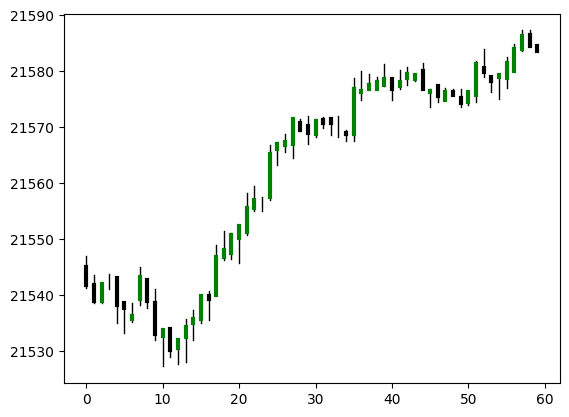

In [21]:
def plot_candles(candles):
    for index in range(len(candles)):
        candle = candles[index]
        c = "green" if candle.c > candle.o else "black"
        plt.plot([index, index], [candle.l, candle.h], linewidth=1, color = "black")
        plt.plot([index, index], [candle.c, candle.o], linewidth=3, color = c)
index+=1

plot_candles(m.m1_candles)
if(current_position.direction != 0):
    plt.axhline(current_position.entry, color = "g" if current_position.direction == 1 else "r")
    plt.axhline(current_position.sl, color = "orange")
if(current_order != None):
    plt.axhline(current_order.entry, color = "g" if current_order.direction == 1 else "r")
    plt.axhline(current_order.sl, color = "orange")
print(current_position.direction, equity_L[-1])

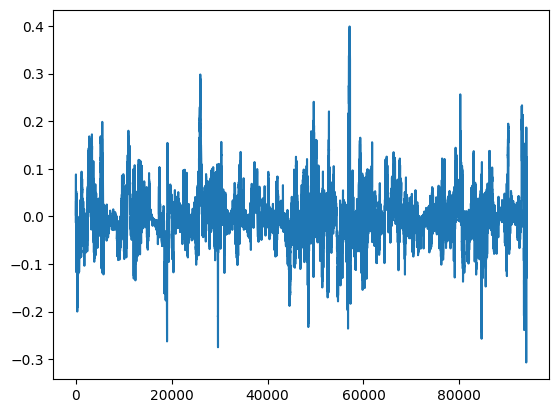

In [22]:
plt.plot(outputs)

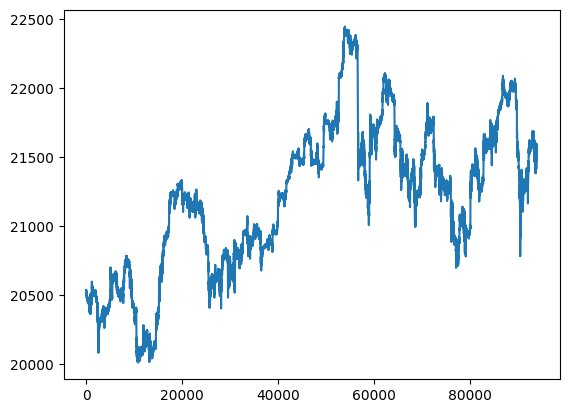

In [23]:
plt.plot([x.c for x in all_candles])

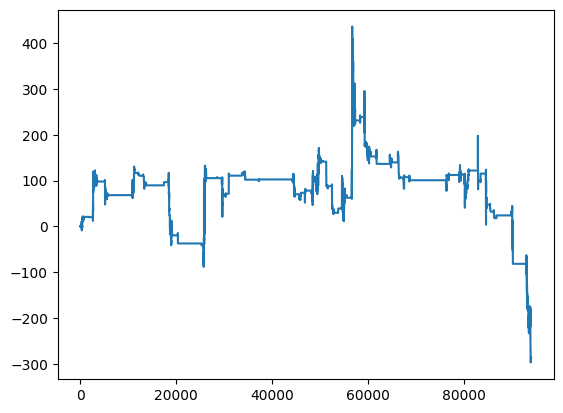

In [24]:
plt.plot(equity_L)